In [1]:
import sys
import os
cellhier_path = 'G:/cellhier'
sys.path.append(cellhier_path)
from cellhier.general import *

# nb_dir = os.path.split(os.getcwd())[0]
# if nb_dir not in sys.path:
#     sys.path.append(nb_dir)
    

%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
%matplotlib inline
%pylab inline
from matplotlib import pyplot as plt
import skimage
import pickle
import seaborn as sns
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from scipy.sparse.csgraph import connected_components
import itertools
from skimage.color import label2rgb
from scipy import ndimage as ndi
from sklearn.neighbors import NearestNeighbors
from scipy.sparse.csgraph import connected_components as cc
from multiprocessing import Pool
import copy
from tqdm.notebook import tqdm

Populating the interactive namespace from numpy and matplotlib


In [2]:
save_path = 'G:/HuBMAP/B008_12/analysis/context/'
cells1 = pd.read_csv("G:/HuBMAP/B008_12/Neighborhoods/05_25_HuBMAP_tunit.csv", index_col=0)
cells2 = cells1.copy()

C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (62,63,70) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
neigh_num = {list(cells2.Neighborhood.unique())[i]:i for i in range(len(cells2.Neighborhood.unique()))}
cells2['neigh_num'] = cells2['Neighborhood'].map(neigh_num)
cells2['neigh_num'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19], dtype=int64)

In [4]:
cells2['donor_tis'] = cells2['donor']+'_'+cells2['tissue']
pat_gp = cells2[['donor_tis','tissue']].drop_duplicates()
pat_to_gp= {a:b for a,b in pat_gp.values}

spot_to_patient = {a:b for a,b in cells2[['unique_region','donor_tis']].drop_duplicates().values}

spot_group_assignment = {a:b for a,b in cells2[['unique_region','tissue']].drop_duplicates().values}
spot_group_assignment;

## Segment the instances and build the tissue graphs for each spot

In [5]:
def segment_instances(spot_id, num_neighbors,min_instance_size,return_kgr = False):
    '''
    This takes a given TMA spot and segments it using connected components of
    k-neighbors graph computed with num_neighbors; 
    only the cells residing in instances with size greater than min_instance_size are returned
    '''
    
    spot = cells2[cells2['unique_region']==spot_id]
    nn = NearestNeighbors(n_neighbors=num_neighbors).fit(spot[['x','y']])
    kgr = nn.kneighbors_graph()


    spot_cn_cell_idxs = {}
    spot_inst_assignments = {}
    instance_assignments = {}
    good_instances = {}

    for cn in range(len(cells2['neigh_num'].unique())):        
        idx = np.where(spot['neigh_num']==cn)[0]
        spot_cn_cell_idxs[cn] = idx
        instance_assignments[cn] = cc(kgr[idx,:][:,idx])[1]
        counts = np.unique(instance_assignments[cn],return_counts=True)
        good_instances[cn] = counts[0][counts[1]>min_instance_size]
        cn_good_inst_idx = np.where(np.isin(instance_assignments[cn],good_instances[cn]))[0]
        good_inst_assignments = instance_assignments[cn][cn_good_inst_idx]
        spot_good_inst_cell_idx = spot_cn_cell_idxs[cn][cn_good_inst_idx]
        
        # this is the pair of index (in the spot) of good cells, as well as their assignments
        spot_inst_assignments[cn] = (spot_good_inst_cell_idx,good_inst_assignments)
    
    if return_kgr:
        return spot, spot_cn_cell_idxs, spot_inst_assignments, kgr
    
    return spot, spot_cn_cell_idxs, spot_inst_assignments

In [6]:
#check that our segmentation is working as we expect for a few randomly selected spot,cn pairs

#plotting params
#pal = sns.color_palette('bright',10)
figsize(10,4)

#generate random samples
spot_ids  = cells2['unique_region'].unique()
spot_cn_combs = list(itertools.product(spot_ids,range(len(cells2.neigh_num.unique()))))
np.random.seed(10)
np.random.shuffle(spot_cn_combs)

#set params
num_neighbors = 10
min_instance_size = 10


In [7]:
neigh_map = {
 'Transit Amplifying Zone': 'darkblue',
 'Microvasculature': 'black',
 'Adaptive Immune Enriched': 'orange',
 'Glandular Epithelial': 'darkorange',
 'CD66+ Mature Epithelial': 'firebrick',
 'Stroma & Innate Immune': 'brown',
 'CD8+ T Enriched IEL': 'green',
 'Mature Epithelial': 'magenta',
 'Innate Immune Enriched': 'skyblue',
 'Outer Follicle': 'navy',
 'Plasma Cell Enriched': 'yellow',
 'Innervated Stroma': 'blueviolet',
 'Stroma': 'gray',
 'Macrovasculature': 'gold',
 'Secretory Epithelial': 'yellowgreen',
 'Smooth Muscle': 'red',
 'Innervated Smooth Muscle': 'lightgreen',
 'Inner Follicle': 'blue',
 'Smooth Muscle & Innate Immune': 'tan',
 'Paneth Enriched': 'lightblue'}

dict_new = {}
for k in neigh_num.keys():
    dict_new[neigh_num[k]]=neigh_map[k]
dict_new

{0: 'magenta',
 1: 'darkblue',
 2: 'skyblue',
 3: 'navy',
 4: 'orange',
 5: 'yellowgreen',
 6: 'firebrick',
 7: 'yellow',
 8: 'brown',
 9: 'tan',
 10: 'black',
 11: 'blueviolet',
 12: 'blue',
 13: 'darkorange',
 14: 'green',
 15: 'gold',
 16: 'red',
 17: 'lightblue',
 18: 'gray',
 19: 'lightgreen'}

In [8]:
pal = list(dict_new.values())

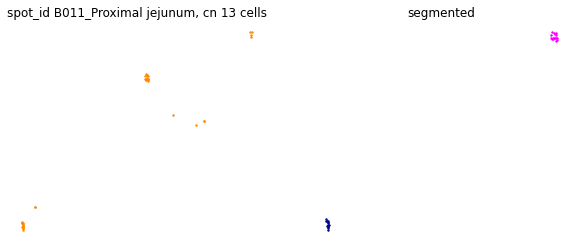

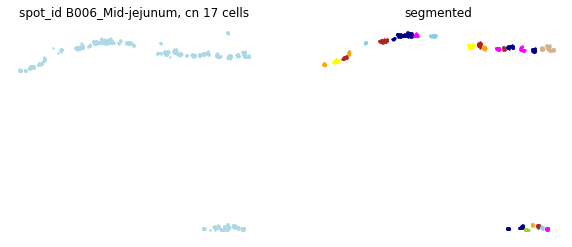

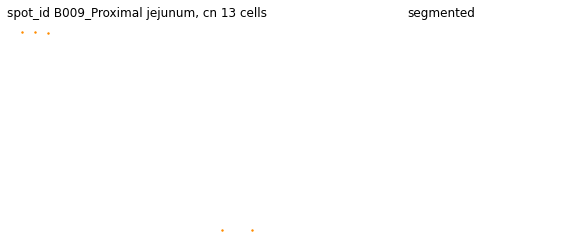

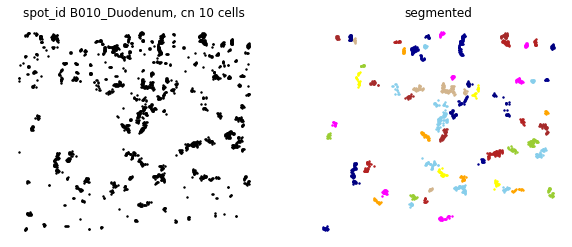

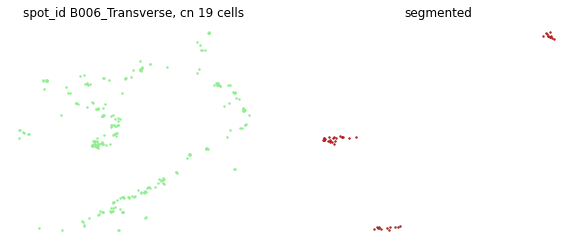

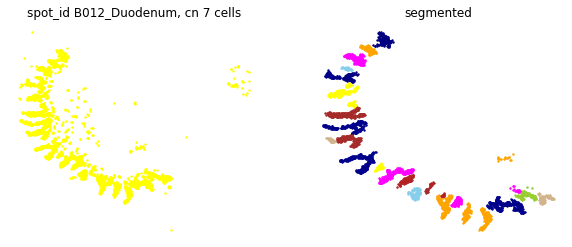

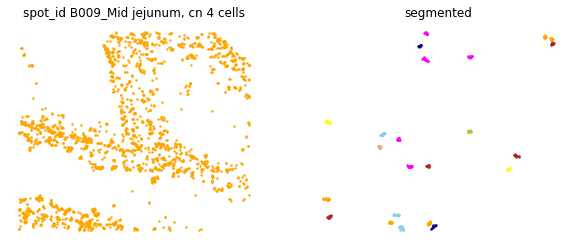

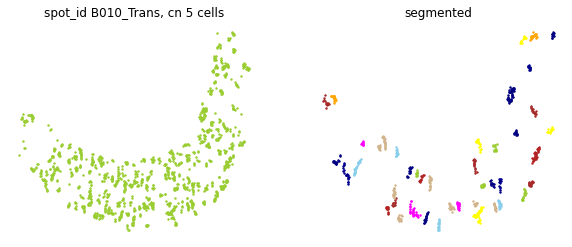

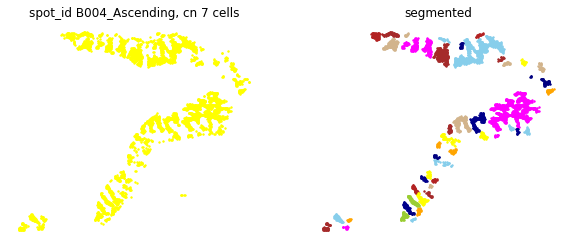

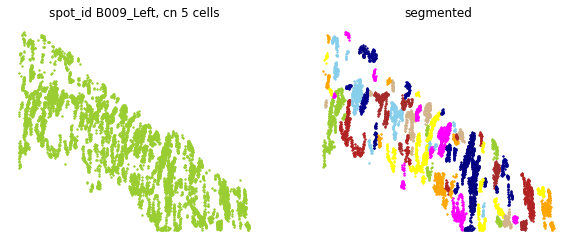

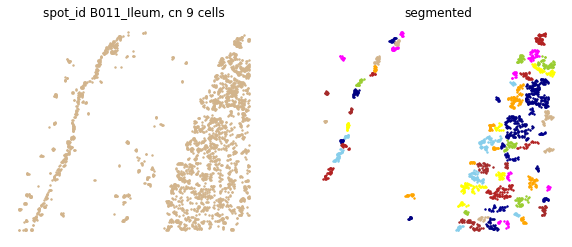

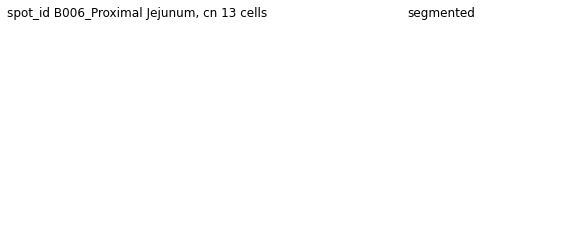

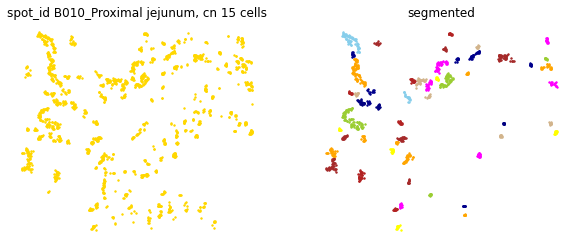

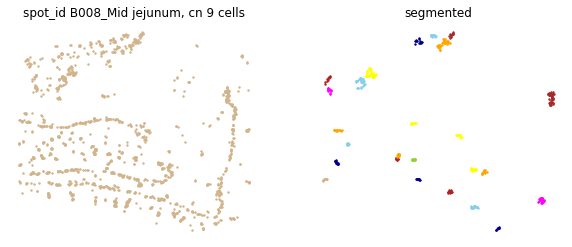

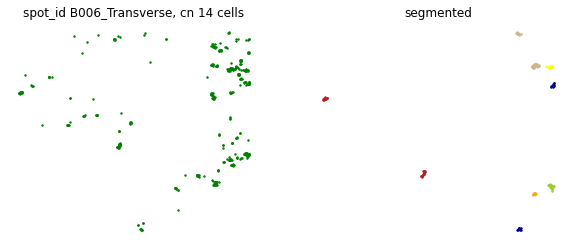

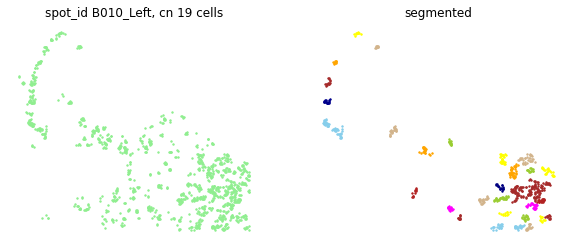

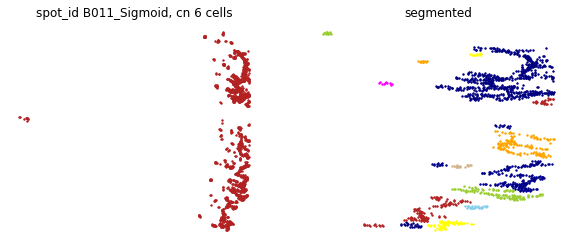

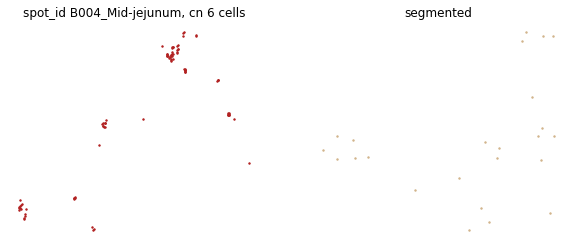

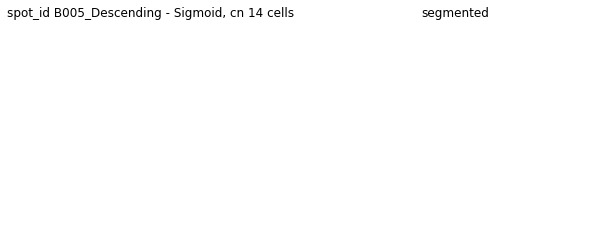

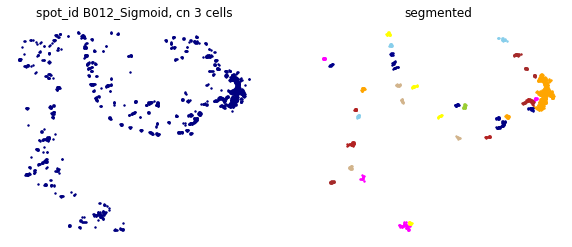

In [9]:

for k in spot_cn_combs[:20]:
    (spot_id, cn) = k
    # use the segment instances script
    spot, spot_cn_cell_idxs, spot_inst_assignments = segment_instances(spot_id,num_neighbors=num_neighbors,min_instance_size=min_instance_size)
    
    
    #plot spot cells of that CN
    plt.subplot(1,2,1)
    sub_spot = spot.iloc[spot_cn_cell_idxs[cn]]
    plt.scatter(sub_spot['x'],sub_spot['y'],c = [pal[cn]],s = 2)
    
    
    plt.title('spot_id {}, cn {} cells'.format(spot_id,cn))
    plt.axis('off')
    
    #plot segmentation colored by instance
    plt.subplot(1,2,2)
    cell_idx,assignment = spot_inst_assignments[cn] 
    for j in unique(assignment):
        
        sub_spot = spot.iloc[cell_idx[assignment ==j]]
        plt.scatter(sub_spot['x'],sub_spot['y'],c = [pal[j%10]],s = 2)
    plt.axis('off')
    plt.title('segmented')
    plt.show()
    

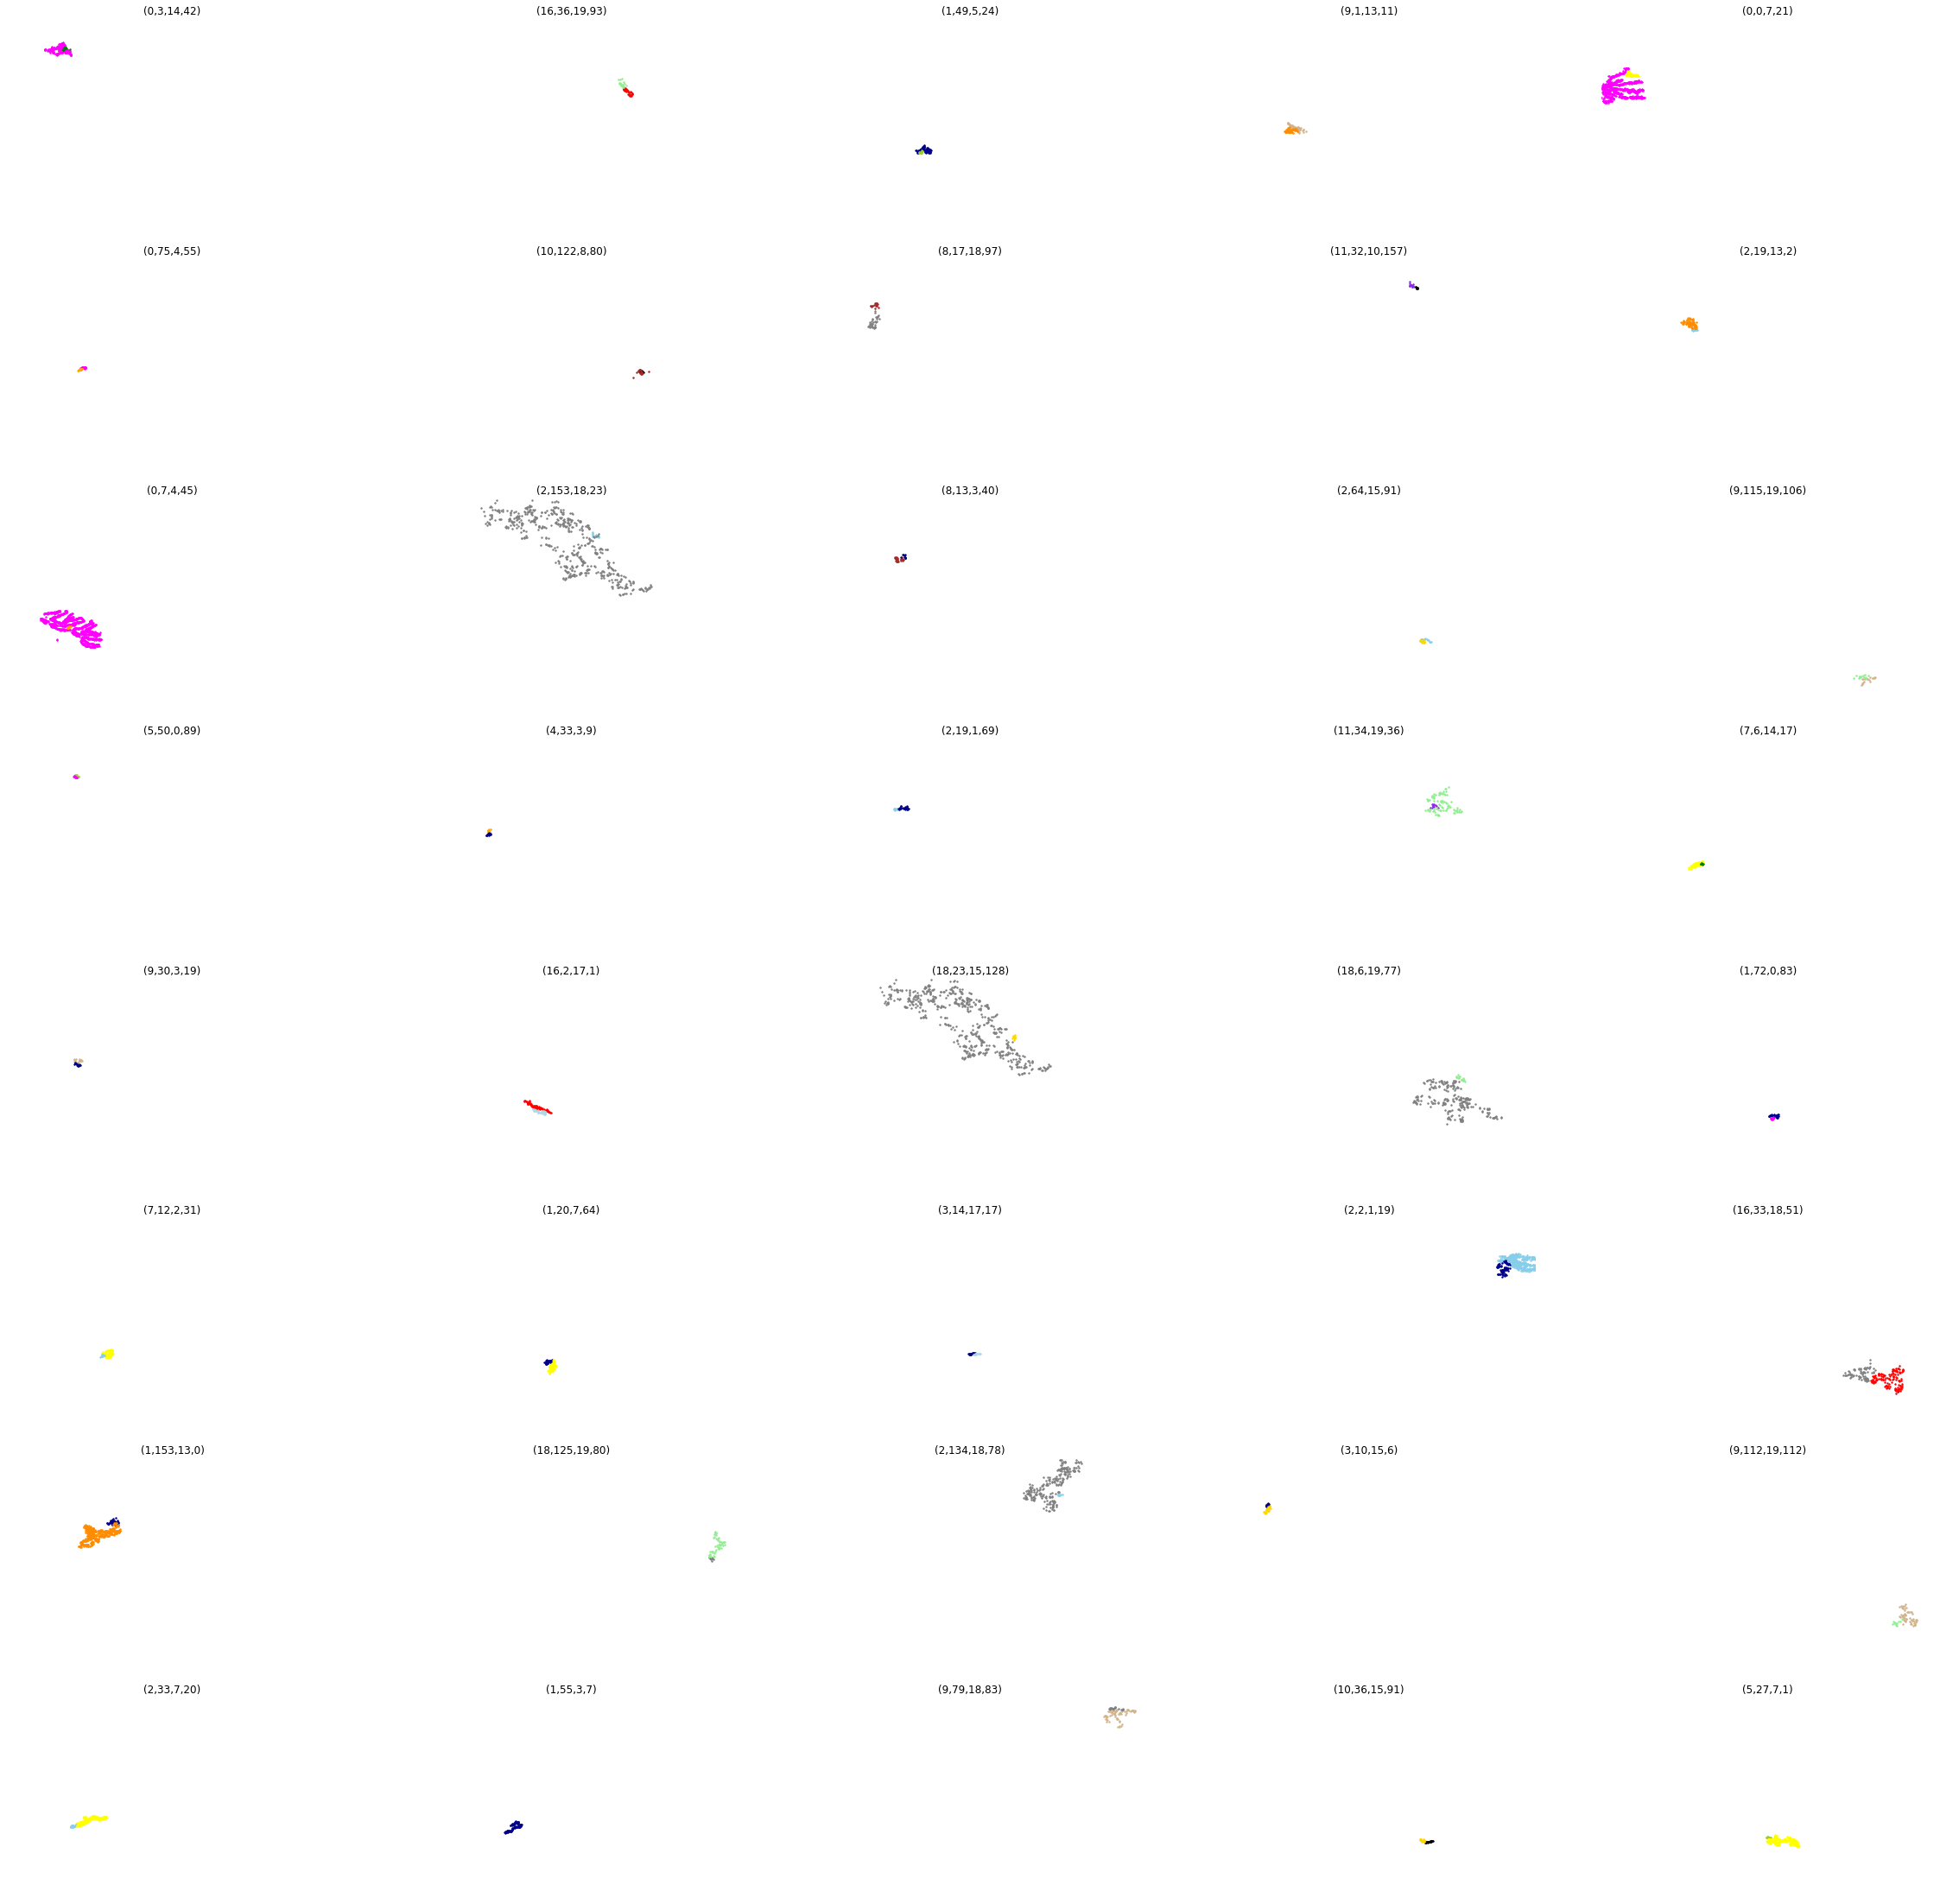

In [10]:
#validate adj graph construction
num_neighbors = 10
min_instance_size = 10

spot_id = 'B012_Duodenum'

spot_data = {}

spot, spot_cn_cell_idxs, inst_assignments,kgr  = segment_instances(spot_id,num_neighbors=num_neighbors,min_instance_size=min_instance_size,return_kgr = True)

spot_adj_graph = nx.Graph()

for cn1 in range(len(cells2.neigh_num.unique())):
    for cn2 in range(cn1):
        e1,e2 = kgr[inst_assignments[cn1][0],:][:,inst_assignments[cn2][0]].nonzero()
        for s,t in set(list(zip(inst_assignments[cn1][1][e1],inst_assignments[cn2][1][e2]))):
            spot_adj_graph.add_edge( (spot_id,cn1,s), (spot_id,cn2,t))
            
xmin = np.min(spot['x'])
xmax = np.max(spot['x'])

ymin = np.min(spot['y'])
ymax = np.max(spot['y'])

figsize(40,40)
edges = list(spot_adj_graph.edges())
np.random.seed(0)
np.random.shuffle(edges)
for i,edge in enumerate(edges[:40]):
    plt.subplot(8,5,i+1)
    s,t = edge
    _,cn1,inst1 = s
    _,cn2,inst2 = t
    good_cn1_cells,good_cn1_cell_inst_assignments = inst_assignments[cn1]
    good_cn2_cells,good_cn2_cell_inst_assignments = inst_assignments[cn2]
    
    
    sub_spot = spot.iloc[good_cn1_cells[good_cn1_cell_inst_assignments == inst1]]
    plt.scatter(sub_spot['x'],sub_spot['y'],c = [pal[cn1]],s = 2)
    
    sub_spot = spot.iloc[good_cn2_cells[good_cn2_cell_inst_assignments == inst2]]
    plt.scatter(sub_spot['x'],sub_spot['y'],c = [pal[cn2]],s = 2)
    
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.axis('off')
    plt.title('({},{},{},{})'.format(cn1,inst1,cn2,inst2))
plt.show()

In [11]:
# construct the adj graphs
num_neighbors = 10
min_instance_size = 10

spot_adj_graphs = {}
spot_data = {}


for spot_id in spot_ids:

    spot_data[spot_id] = segment_instances(spot_id,num_neighbors=num_neighbors,min_instance_size=min_instance_size,return_kgr = True)
    spot, spot_cn_cell_idxs, inst_assignments,kgr  = spot_data[spot_id]

    for cn1 in range(len(cells2.neigh_num.unique())):
        for cn2 in range(cn1):
            e1,e2 = kgr[inst_assignments[cn1][0],:][:,inst_assignments[cn2][0]].nonzero()
            for s,t in set(list(zip(inst_assignments[cn1][1][e1],inst_assignments[cn2][1][e2]))):
                spot_adj_graphs.setdefault(spot_id, nx.Graph()).add_edge( (spot_id,cn1,s), (spot_id,cn2,t))
    

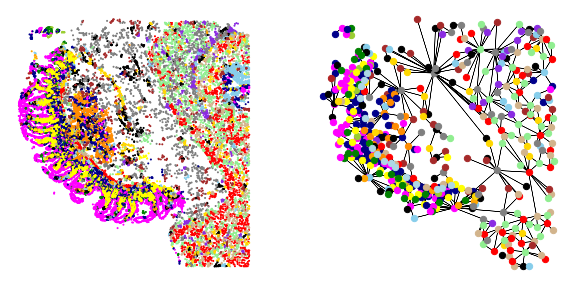

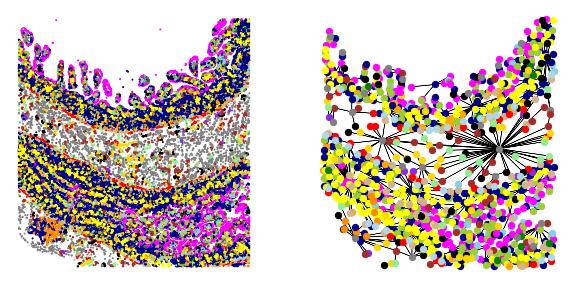

In [12]:
# visualizing a tissue graph

for spot_id in ['B012_Duodenum', 'B011_Duodenum']:
    spot, spot_cn_cell_idxs, inst_assignments, kgr = spot_data[spot_id]

    figsize(10,5)


    plt.subplot(1,2,1)
    plt.scatter(spot['x'],spot['y'], c = [pal[cn] for cn in spot['neigh_num']],s  = 1)
    plt.axis('off');

    plt.subplot(1,2,2)
    pos = {}
    draw = spot_adj_graphs[spot_id]

    for n in draw.nodes():
        cn = n[1]
        cn_cells, cn_assignments = inst_assignments[cn]
        sub_spot = spot.iloc[cn_cells[cn_assignments == n[2]]]
        pos[n] = np.mean(sub_spot['x']),np.mean(sub_spot['y'])
        plt.scatter(pos[n][0],pos[n][1], c = [pal[n[1]]], s =40)

    for s,t in draw.edges():
        x = pos[s][0]
        y = pos[s][1]
        dx = (pos[t][0]-x)
        dy = (pos[t][1]-y)


        alpha = 1
        col = 'black'

        plt.arrow(x,y,dx,dy,head_length =0, head_width = 0,length_includes_head= True,alpha = alpha,lw = 0.5,color = col,zorder = -1)

    plt.axis('off');
    plt.show()

## fragmentation

In [13]:
from scipy.stats import mannwhitneyu

In [14]:
spot_counts = {}
for a,v in spot_adj_graphs.items():
    spot_counts[a] = {'edge': np.mean([v.degree(n) for n in v.nodes()]), 'node': len(v.nodes)}

Text(0.5, 6.800000000000029, '')

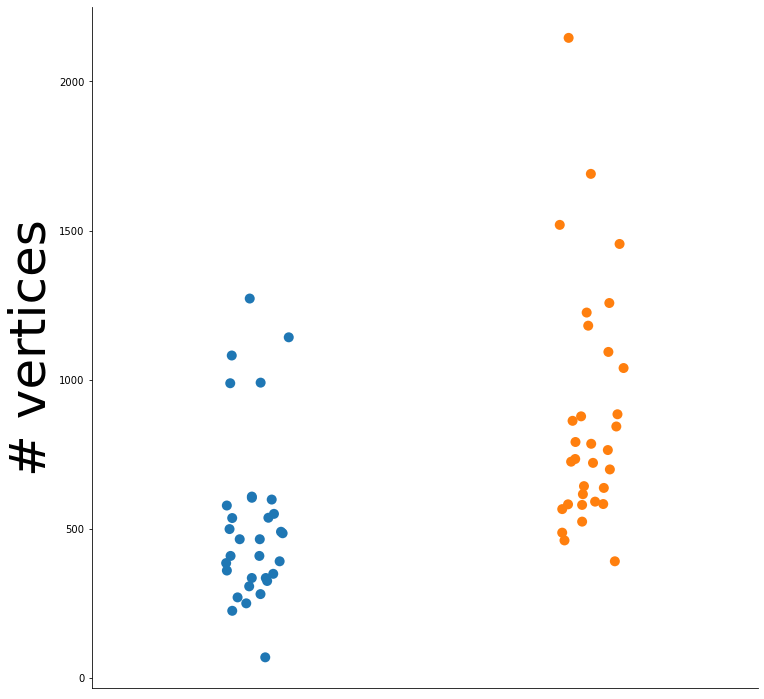

In [15]:
df_concat = pd.concat([pd.DataFrame({'gp':spot_group_assignment}),pd.DataFrame(spot_counts).T], axis = 1)
sns.catplot(data = df_concat,
            x = 'gp',
            y = 'node',height = 10, s = 10)

plt.xticks([])
plt.ylabel('# vertices',fontsize = 50)
plt.xlabel('')

Text(0.5, 6.800000000000029, '')

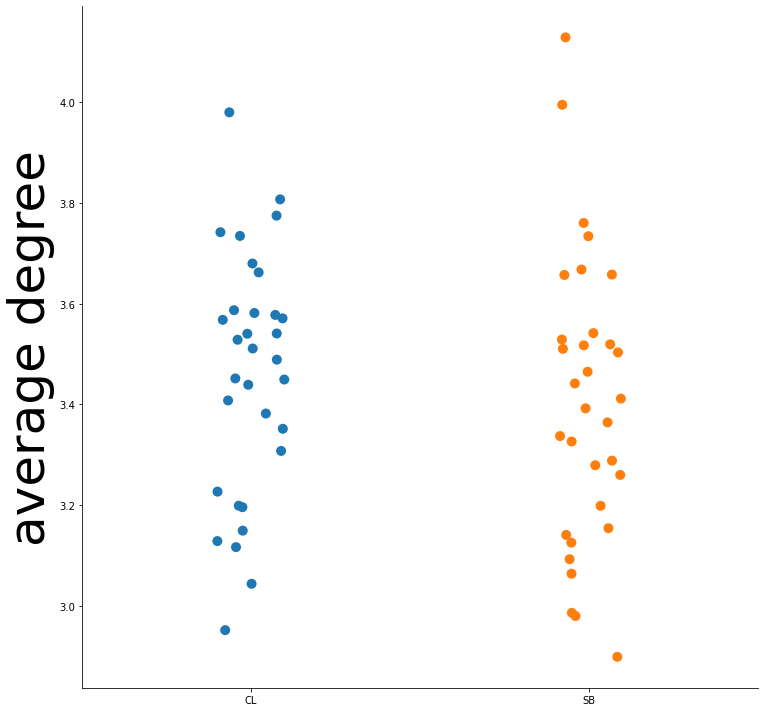

In [16]:

sns.catplot(data = df_concat,
            x = 'gp',
            y = 'edge',height = 10, s = 10)
plt.ylabel('average degree',fontsize = 50)
plt.xlabel('')

### Group TMA cores to compute p values

In [17]:
dd = pd.concat([pd.DataFrame({'gp':spot_group_assignment}),pd.DataFrame({'pat':spot_to_patient}),pd.DataFrame(spot_counts).T], axis = 1)
dd = dd.groupby(['gp','pat'])[['edge','node']].mean().reset_index()
print(mannwhitneyu(dd['node'][dd['gp']=='SB'],dd['node'][dd['gp']=='CL']))
print(mannwhitneyu(dd['edge'][dd['gp']=='SB'],dd['edge'][dd['gp']=='CL']))

MannwhitneyuResult(statistic=5.0, pvalue=0.0026924700000735156)
MannwhitneyuResult(statistic=27.0, pvalue=0.31825124345693306)


# Extension frequencies

### Finding the rules in group1: high vs group2: low drug delivery patient

In [18]:
adj_graphs = {}
adj_graph = nx.Graph()
for k,v in spot_adj_graphs.items():
    for s,t in v.edges():
        adj_graphs.setdefault(spot_group_assignment[k],nx.Graph()).add_edge(s,t)
        adj_graph.add_edge(s,t)

In [19]:
#start by defining a statistic over a graph, e.g.

def total_edgetype_counts(graph):
    counts = {}
    for s,t in graph.edges():
        key = tuple(sorted([s[1],t[1]]))
        counts.setdefault(key,0)
        counts[key] +=1
    return counts


#build a partition into isomorphism up to a certain level of structure
nodes_by_isom = {}
nodes_by_isom['SB'] = {}
nodes_by_isom['CL'] = {}


In [20]:
for v in adj_graph.nodes():
    spot, cn, _ = v
    
    # try that any instance can be mapped to any instance *within the same spot*
    isom = spot
    
    #edges_class = tuple(sorted(set([edge[1][1] for edge in adj_graph.edges(v)])))
    nodes_by_isom[spot_group_assignment[spot]].setdefault(isom,set()).add(v)
    

In [21]:
ty_nodes = {}
ty_edges = {}
for n in adj_graph.nodes():
    pat = spot_to_patient[n[0]]
    cn = n[1]
    ty_nodes.setdefault(pat,{}).setdefault(cn,set()).add(n)
    for _,e1 in adj_graph.edges(n):
        cn1 = e1[1]
        pair = tuple(sorted([cn,cn1]))
        ty_edges.setdefault(pat,{}).setdefault((cn,pair),set()).add(n)
       

In [22]:
all_edge_types = set()
for e in ty_edges.keys():
    all_edge_types = all_edge_types.union(ty_edges[e].keys())
    
all_node_types = set()
for e in ty_nodes.keys():
    all_node_types = all_node_types.union(ty_nodes[e].keys())

In [23]:
# observed distribution
count_base = {}
count_edges = {}
lift_freq = {}

for node_type in all_node_types:
    for pat,gp in pat_to_gp.items():
        to_add = len(ty_nodes[pat].setdefault(node_type,set()))
        cb = count_base.setdefault((gp,node_type), 0)
        cb = cb + to_add
        count_base[(gp,node_type)] = cb


for edge_type in all_edge_types:
    for pat,gp in pat_to_gp.items():
        to_add = len(ty_edges[pat].setdefault(edge_type,set()))
        ce = count_edges.setdefault((gp,edge_type), 0)
        ce = ce + to_add
        count_edges[(gp,edge_type)] = ce

    freq = count_edges[('SB',edge_type)]/(1+count_base[('SB', edge_type[0])])
    if freq > 1:
        print(edge_type)
        print(count_edges[(1,edge_type)])
        print(edge_type[0],count_base[(1,edge_type[0])])
        print('aaa')
    lift_freq['act',edge_type, 1] = count_edges[('SB',edge_type)]/(1+count_base[('SB', edge_type[0])])
    lift_freq['act',edge_type, 2] = count_edges[('CL',edge_type)]/(1+count_base[('CL', edge_type[0])])

In [24]:
# gp1: high drug group
# gp2: low drug group
obs_lfs = pd.DataFrame({'gp1':{j: lift_freq['act',j,1] for j in all_edge_types }, 'gp2': {j: lift_freq['act',j,2] for j in all_edge_types}})

In [25]:
cn_names = {i:i for i in range(20)}
cn_names

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19}

C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\seaborn\matrix.py:1205: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(**tight_params)


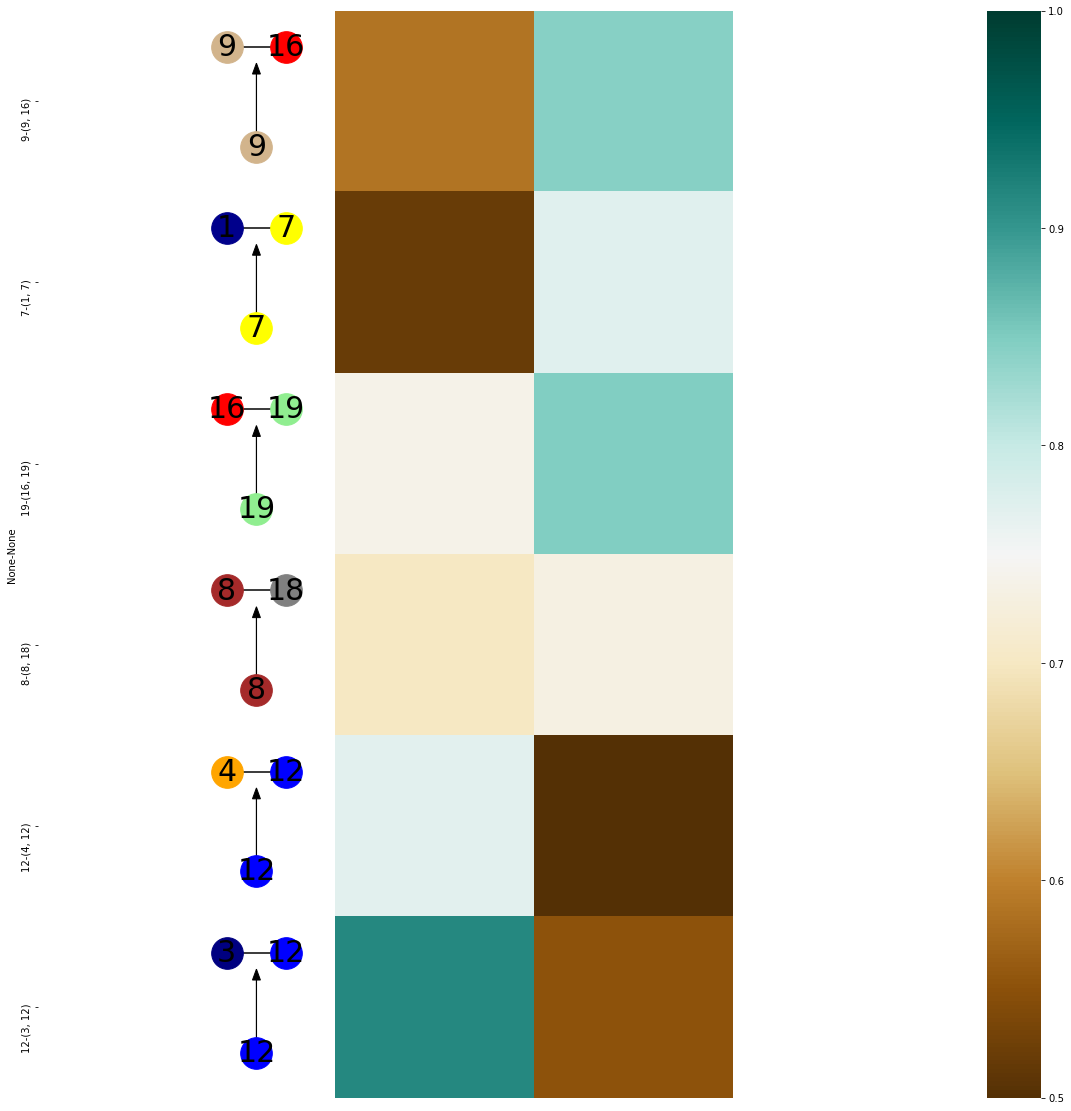

In [26]:
figsize(20,20)
oo = obs_lfs
oo['not1'] = True
#oo['not1'] = [1 not in a[1] for a in oo.index.values ]
q = ((oo['gp2']>.7)|(oo['gp1']>.7)) & (oo['not1'])
g =sns.clustermap(oo[q].iloc[:,:2], figsize = (1,1));
plt.close()

sns.heatmap(oo[q].iloc[g.dendrogram_row.reordered_ind,:-1],cmap = 'BrBG', vmin = 0.5,vmax = 1) 
j = 0
for s, t in oo[q].iloc[g.dendrogram_row.reordered_ind,:-1].index.values:
    j+=1
    
    plt.scatter(-0.4,0.75 + (j-1), c = [pal[s]], s = 1000)
    plt.text(-0.4,0.75 + (j-1),cn_names[s], ha = 'center', va = 'center',fontsize = 30)
    plt.scatter(-0.55,0.2 + (j-1),c = [pal[t[0]]], s = 1000)
    plt.text(-0.55,0.2 + (j-1),cn_names[t[0]], ha = 'center', va = 'center',fontsize = 30)
    plt.scatter(-0.25,0.2 + (j-1),c = [pal[t[1]]], s = 1000)
    plt.text(-0.25,0.2 + (j-1),cn_names[t[1]], ha = 'center', va = 'center',fontsize = 30)
    plt.arrow(-0.4,0.75+j-1, 0, -0.4,  head_width= 0.04, color = 'black',zorder = -2)
    plt.plot([-0.55,-0.25], [0.2 + (j-1),0.2 + (j-1)],zorder = -1, color = 'black')

plt.xticks([])
plt.xlim(-1.5,3)

plt.savefig(save_path+'window10_2-chain_extensionfreq10.png',bbox_inches = 'tight')
plt.show()

In [27]:
neigh_num

{'Mature Epithelial': 0,
 'Transit Amplifying Zone': 1,
 'Innate Immune Enriched': 2,
 'Outer Follicle': 3,
 'Adaptive Immune Enriched': 4,
 'Secretory Epithelial': 5,
 'CD66+ Mature Epithelial': 6,
 'Plasma Cell Enriched': 7,
 'Stroma & Innate Immune': 8,
 'Smooth Muscle & Innate Immune': 9,
 'Microvasculature': 10,
 'Innervated Stroma': 11,
 'Inner Follicle': 12,
 'Glandular Epithelial': 13,
 'CD8+ T Enriched IEL': 14,
 'Macrovasculature': 15,
 'Smooth Muscle': 16,
 'Paneth Enriched': 17,
 'Stroma': 18,
 'Innervated Smooth Muscle': 19}

## Differences in extension frequencies via permuting group assignments

In [28]:
# https://stackoverflow.com/questions/53247985/tqdm-4-28-1-in-jupyter-notebook-intprogress-not-found-please-update-jupyter-an
#!conda install ipywidgets

In [29]:
# permutation distribution of extension frequencies
for gp_perm in range(10000):
    pat_to_gp_samp = {a:b for a,b, in zip(pat_gp['donor_tis'].values,pat_gp['tissue'].sample(frac = 1,random_state = gp_perm).values)}
    
    

    count_base = {} 
    for node_type in all_node_types:
        for pat,gp in pat_to_gp_samp.items():
            to_add = len(ty_nodes[pat].setdefault(node_type,set()))
            cb = count_base.setdefault((gp,node_type), 0)
            cb = cb + to_add
            count_base[(gp,node_type)] = cb
            
    count_edges = {}

    for edge_type in all_edge_types:
        for pat,gp in pat_to_gp_samp.items():
            to_add = len(ty_edges[pat].setdefault(edge_type,set()))
            ce = count_edges.setdefault((gp,edge_type), 0)
            ce = ce + to_add
            count_edges[(gp,edge_type)] = ce
            
            
        lift_freq[gp_perm,edge_type, 1] = count_edges[('SB',edge_type)]/(1+count_base[('SB', edge_type[0])])
        lift_freq[gp_perm,edge_type, 2] = count_edges[('CL',edge_type)]/(1+count_base[('CL', edge_type[0])])
         

In [30]:
# bonferroni corrected permutation p-values
perm_dist = pd.DataFrame({i:{j:lift_freq[i,j,1]- lift_freq[i,j,2] for j in all_edge_types} for i in range(10000)})

In [31]:
obs = pd.DataFrame({'obs':{j: lift_freq['act',j,1] -  lift_freq['act',j,2] for j in all_edge_types }})
pvals = np.minimum(1.0,90*(1 - np.mean((obs.values>0)*(obs.values> perm_dist.values) + (obs.values<0)*(obs.values< perm_dist.values),axis = 1)))
sig_lfs =  obs_lfs.loc[obs[pvals< 0.05].index.values]

In [32]:
# obs_lfs[['gp1','gp2']].loc[k[0]]
# obs_lfs[['gp1','gp2']].loc[k[1]]

# #.corr()['gp1'][1]

In [72]:
obs_lfs['gp1'].loc[10]

(10, 16)    0.080259
(10, 15)    0.215852
(1, 10)     0.131107
(5, 10)     0.146560
(10, 19)    0.051844
(4, 10)     0.172981
(6, 10)     0.003490
(10, 11)    0.030409
(3, 10)     0.079761
(0, 10)     0.154536
(10, 14)    0.163509
(7, 10)     0.218345
(9, 10)     0.100698
(10, 17)    0.035892
(10, 12)    0.009970
(8, 10)     0.113659
(10, 18)    0.342971
(10, 13)    0.015952
(2, 10)     0.183948
Name: gp1, dtype: float64

In [90]:
#Find frequencies per group to plot
test1 = obs_lfs.reset_index()
test1.rename(columns={'level_0':'key','level_1':'combo'}, inplace=True)
test1[['k1', 'k2']] = pd.DataFrame(test1['combo'].tolist(), index=test1.index)
test1['key2'] = test1[['k1','key','k2']].apply(lambda x:x.k1 if x.k1!=x.key else x.k2, axis=1)
cols1 = ['key', 'gp1',  'key2']
cols2 = ['key', 'gp2', 'key2']
testgp1 = test1[cols1]
testgp1['group'] = 'group1'
testgp2 = test1[cols2]
testgp2['group'] = 'group2'
testgp1.rename(columns={'gp1':'gp2'},inplace=True)
totalgp = pd.concat([testgp1,testgp2])
#tt2 = test1.pivot(index='key2', columns='key', values=['gp1','gp2'])
totalgp

C:\Users\AKOYA-~1\AppData\Local\Temp/ipykernel_8360/1031064007.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testgp1['group'] = 'group1'
C:\Users\AKOYA-~1\AppData\Local\Temp/ipykernel_8360/1031064007.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testgp2['group'] = 'group2'
C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: h

,key,gp2,key2,group
0,10,0.080259,16,group1
1,2,0.124744,15,group1
2,5,0.016812,18,group1
3,12,0.014286,15,group1
4,2,0.374233,10,group1
...,...,...,...,...
365,14,0.482558,0,group2
366,0,0.039251,10,group2
367,16,0.082500,8,group2
368,13,0.000000,4,group2


In [91]:
def swarm_box(data, grouping='group', per_cat='key', norm=True,\
              figure_sizing=(10,5), save_name=None, h_order=None):
    
    plt.style.use(['default'])
    #GENERAL GRAPH SETTINGs
    #font size of graph
    SMALL_SIZE = 14
    MEDIUM_SIZE = 16
    BIGGER_SIZE = 18

    #Settings for graph
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    
    #Order by average
    plot_order = data.groupby(per_cat).mean().reset_index().sort_values(by='gp2')[per_cat].to_list()

    if h_order is None:
        h_order = list(data[grouping].unique()) 
    
    #swarmplot to compare clustering
    plt.figure(figsize=figure_sizing)
    ax = sns.boxplot(data = data, x=per_cat,  y='gp2', hue = grouping, dodge=True, order=plot_order,\
                     hue_order=h_order)
    ax = sns.swarmplot(data = data, x=per_cat, y='gp2', hue = grouping, dodge=True, order=plot_order,\
                      hue_order=h_order, edgecolor='black',linewidth=1)
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))
    #ax.set_yscale(\log\)
    plt.xlabel('')
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[:len(data[grouping].unique())], labels[:len(data[grouping].unique())],\
               bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False)
    plt.xticks(rotation=90)
    sns.despine(trim=True)
    if save_name:
        plt.savefig(save_path+save_name+'_swarm_boxplot.png', format='png', dpi=300, transparent=True, bbox_inches='tight')
    
    return data


C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 15.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 22.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 31.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users

,key,gp2,key2,group
0,10,0.080259,16,group1
1,2,0.124744,15,group1
2,5,0.016812,18,group1
3,12,0.014286,15,group1
4,2,0.374233,10,group1
...,...,...,...,...
365,14,0.482558,0,group2
366,0,0.039251,10,group2
367,16,0.082500,8,group2
368,13,0.000000,4,group2


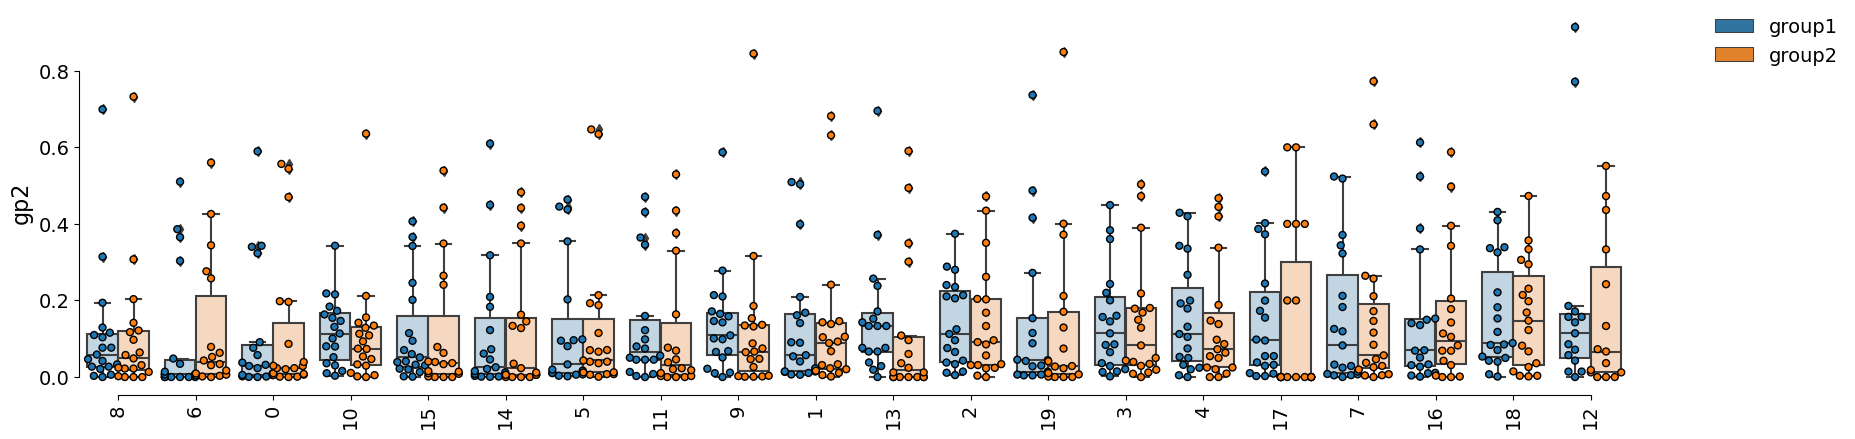

In [92]:
swarm_box(data=totalgp, grouping='group', per_cat='key', norm=True,\
              figure_sizing=(20,5), save_name=None, h_order=None)

In [ ]:
for k in obs_lfs.index.values.tolist():
    for shkey in shared_keys:
        if k[0]==int(shkey.split('_')[0]) and k[1][1]==int(shkey.split('_')[1]):

In [94]:
shtuple_list = []
for shkey in shared_keys:
    ab = (int(shkey.split('_')[0]), int(shkey.split('_')[1]))
    shtuple_list.append(ab)
shtuple_list

[(3, 8),
 (2, 16),
 (4, 19),
 (1, 19),
 (10, 18),
 (7, 16),
 (1, 7),
 (1, 11),
 (3, 15),
 (15, 16),
 (11, 16),
 (7, 11),
 (0, 15),
 (0, 18),
 (10, 19),
 (16, 18),
 (4, 7),
 (3, 4),
 (0, 9),
 (6, 10),
 (4, 12),
 (3, 12),
 (5, 9),
 (5, 11),
 (1, 8),
 (0, 8),
 (7, 8),
 (0, 10),
 (9, 16),
 (3, 7),
 (3, 11),
 (0, 3),
 (1, 16),
 (1, 9),
 (8, 9),
 (2, 19),
 (0, 4),
 (5, 10),
 (7, 19),
 (10, 14),
 (5, 8),
 (4, 5),
 (1, 18),
 (16, 19),
 (3, 19),
 (0, 1),
 (5, 19),
 (5, 18),
 (0, 7),
 (1, 10),
 (18, 19),
 (4, 15),
 (9, 10),
 (7, 15),
 (8, 18),
 (4, 18),
 (5, 7),
 (0, 6),
 (4, 8),
 (11, 18),
 (5, 15),
 (1, 5),
 (1, 15),
 (10, 11),
 (15, 18),
 (5, 16)]

In [98]:
test1.loc[test1.combo.isin(shtuple_list)]

,key,combo,gp1,gp2,not1,k1,k2,key2
2,5,"(5, 18)",0.016812,0.040096,True,5,18,18
6,1,"(1, 18)",0.054034,0.067562,True,1,18,18
9,0,"(0, 3)",0.031892,0.028546,True,0,3,3
11,18,"(8, 18)",0.325638,0.294599,True,8,18,8
12,1,"(1, 8)",0.014804,0.010827,True,1,8,8
...,...,...,...,...,...,...,...,...
359,11,"(7, 11)",0.045213,0.020460,True,7,11,7
363,15,"(0, 15)",0.019983,0.009804,True,0,15,0
364,5,"(5, 15)",0.014633,0.012029,True,5,15,15
366,0,"(0, 10)",0.091076,0.039251,True,0,10,10


In [99]:
#Find frequencies per group to plot
test1 = obs_lfs.reset_index()
test1.rename(columns={'level_0':'key','level_1':'combo'}, inplace=True)
test1[['k1', 'k2']] = pd.DataFrame(test1['combo'].tolist(), index=test1.index)
test1['key2'] = test1[['k1','key','k2']].apply(lambda x:x.k1 if x.k1!=x.key else x.k2, axis=1)
test2 = test1.loc[test1.combo.isin(shtuple_list)]
cols1 = ['key', 'gp1',  'key2']
cols2 = ['key', 'gp2', 'key2']
testgp1 = test2[cols1]
testgp1['group'] = 'group1'
testgp2 = test2[cols2]
testgp2['group'] = 'group2'
testgp1.rename(columns={'gp1':'gp2'},inplace=True)
totalgp = pd.concat([testgp1,testgp2])
#tt2 = test1.pivot(index='key2', columns='key', values=['gp1','gp2'])
totalgp

C:\Users\AKOYA-~1\AppData\Local\Temp/ipykernel_8360/2140584555.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testgp1['group'] = 'group1'
C:\Users\AKOYA-~1\AppData\Local\Temp/ipykernel_8360/2140584555.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testgp2['group'] = 'group2'
C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

,key,gp2,key2,group
2,5,0.016812,18,group1
6,1,0.054034,18,group1
9,0,0.031892,3,group1
11,18,0.325638,8,group1
12,1,0.014804,8,group1
...,...,...,...,...
359,11,0.020460,7,group2
363,15,0.009804,0,group2
364,5,0.012029,15,group2
366,0,0.039251,10,group2


C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 18.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 14.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


,key,gp2,key2,group
2,5,0.016812,18,group1
6,1,0.054034,18,group1
9,0,0.031892,3,group1
11,18,0.325638,8,group1
12,1,0.014804,8,group1
...,...,...,...,...
359,11,0.020460,7,group2
363,15,0.009804,0,group2
364,5,0.012029,15,group2
366,0,0.039251,10,group2


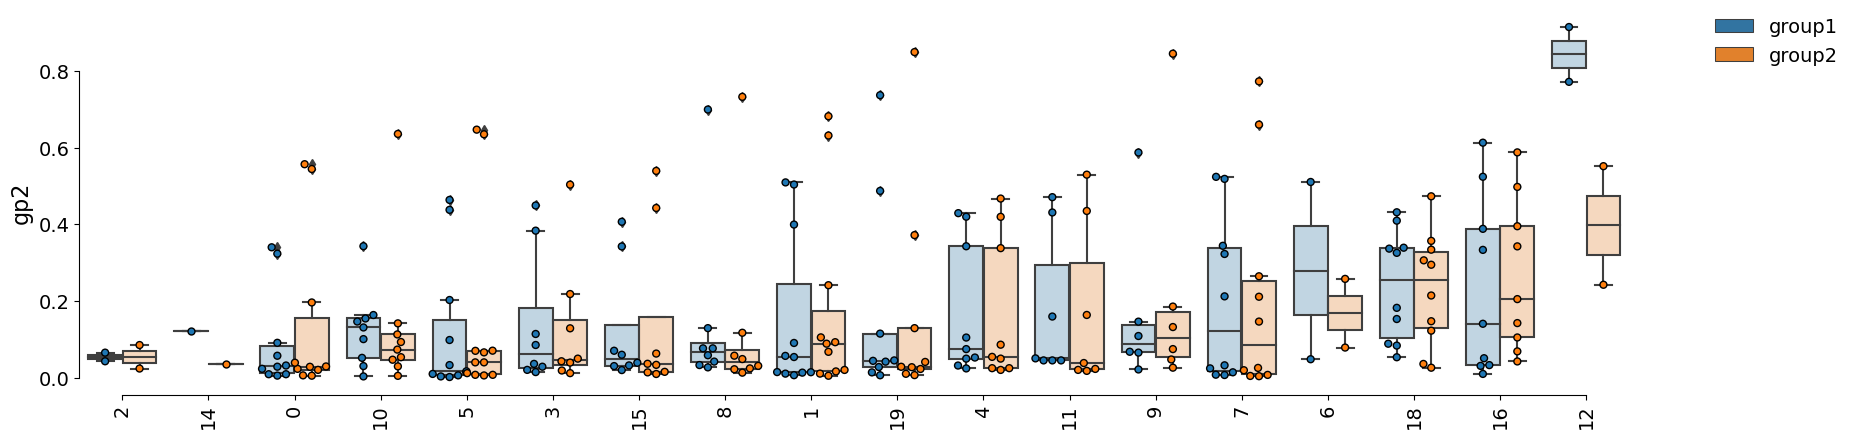

In [100]:
swarm_box(data=totalgp, grouping='group', per_cat='key', norm=True,\
              figure_sizing=(20,5), save_name=None, h_order=None)

In [105]:
countx = totalgp.groupby(['key']).count()['key2']
countx.sort_values()

key
14     2
2      4
6      4
12     4
9     12
11    14
8     16
3     16
15    16
16    18
19    18
4     18
10    18
18    20
7     20
0     20
5     22
1     22
Name: key2, dtype: int64

In [33]:
#Find correlation between motif frequencies
cor_dict={}
for neigh in list(obs_lfs.index.levels[0]):
    cor_dict[neigh] = obs_lfs[['gp1','gp2']].loc[neigh].corr()['gp1'][1]

df_cor = pd.DataFrame(cor_dict.items(), columns=['neigh', 'corr'])
df_sort_cor = df_cor.sort_values('corr')
df_sort_cor

,neigh,corr
17,17,0.442823
13,13,0.514658
2,2,0.589686
12,12,0.601400
6,6,0.646202
0,0,0.649475
5,5,0.724810
10,10,0.729583
3,3,0.750079
4,4,0.790244


In [70]:
#From below shared_keys

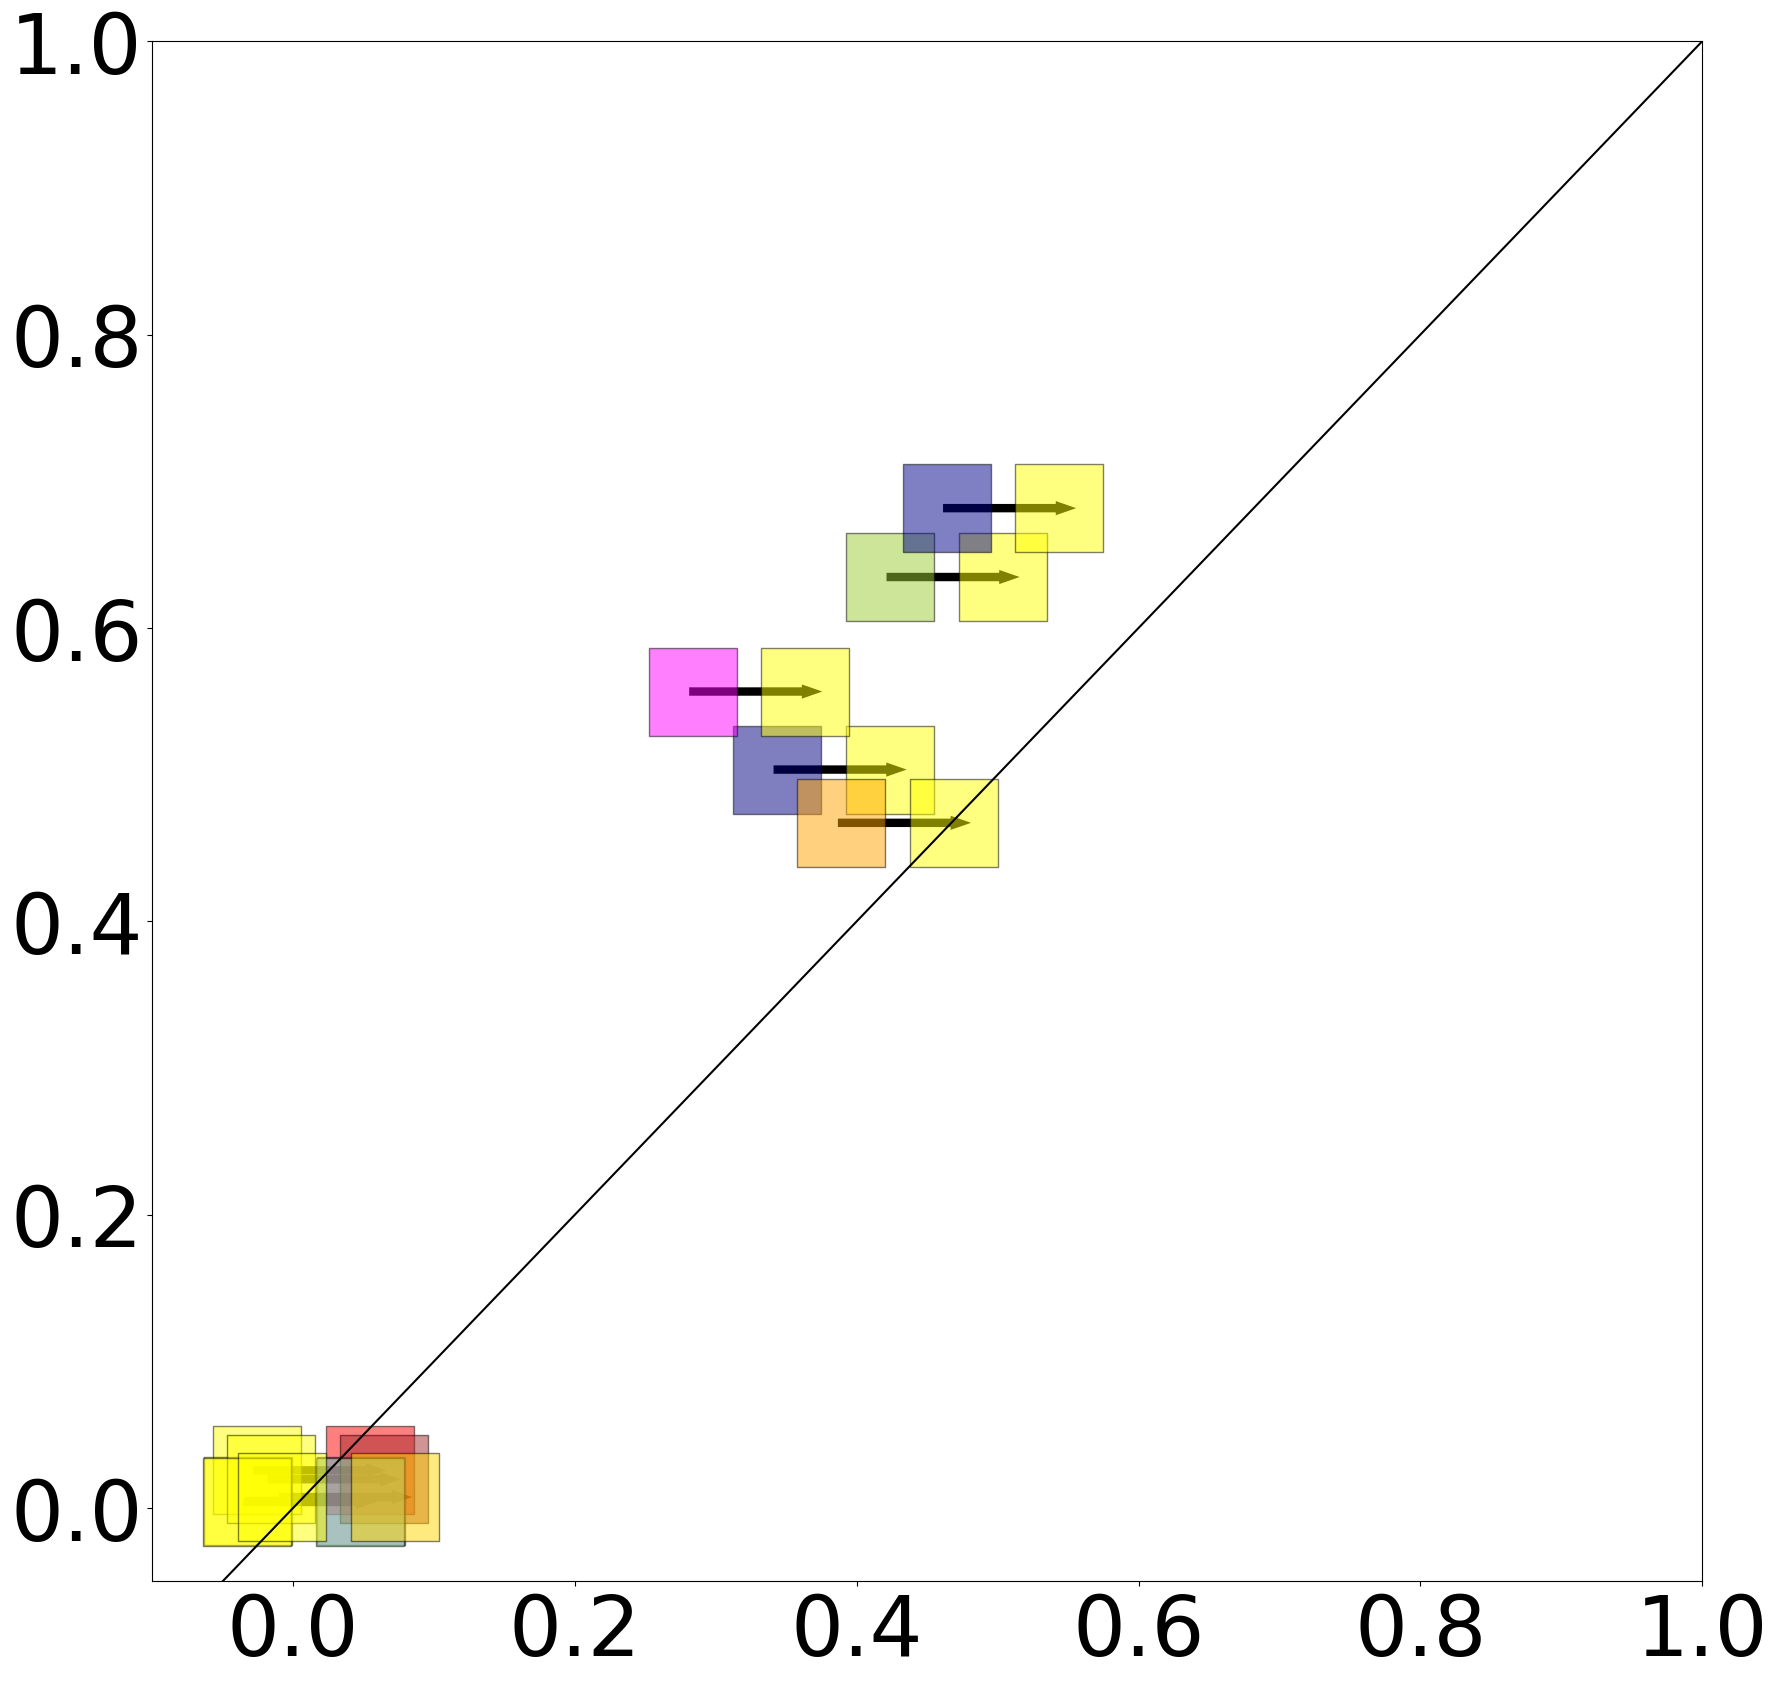

In [110]:
figsize(20,20)
#pal = sns.color_palette('bright',11)
for k in obs_lfs.index.values.tolist():
    for shkey in shared_keys:
        if k[0]==int(shkey.split('_')[0]) and k[1][1]==int(shkey.split('_')[1]):
            if k[0]==7 or k[1][1]==7:
                
                x = (obs_lfs['gp1'].loc[k[0]])[k[1]]
                y = (obs_lfs['gp2'].loc[k[0]])[k[1]]
                plt.scatter(x-0.04,y, c= [pal[k[0]]], s = 4000,alpha = 0.5, linewidths=1, edgecolors='black', marker='s')

                new = list(set(list(k[1]))-set([k[0]]))[0]
                plt.scatter(x+0.04,y, c= [pal[new]], s= 4000,alpha = 0.5, linewidths=1, edgecolors='black', marker='s')
                plt.arrow(x-0.04,y,0.08,0,zorder = -10,lw = 5)
    #     if x>0.3 and y<0.1:
#         plt.text(x+0.03,y,cn_names[new],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#         plt.text(x-0.03,y,cn_names[k[0]],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#         print(cn_names[k[0]],'-',cn_names[new])
#     if x<0.1 and y>0.3:
#         plt.text(x+0.03,y,cn_names[new],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#         plt.text(x-0.03,y,cn_names[k[0]],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#         print(cn_names[k[0]],'-',cn_names[new])
#     if x>0.8 or y>0.8:
#         plt.text(x+0.03,y,cn_names[new],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#         plt.text(x-0.03,y,cn_names[k[0]],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#         print(cn_names[k[0]],'-',cn_names[new])
plt.ylim(-0.05,1)
plt.xlim(-0.1,1)
plt.xticks(fontsize = 60);
plt.yticks(fontsize = 60);
plt.plot([-0.5,1],[-0.5,1],c = 'black')
plt.savefig(save_path+'window10_2-chain_frequency10_neigh_plasma_permute.png',bbox_inches = 'tight', transparent=True)
plt.show()

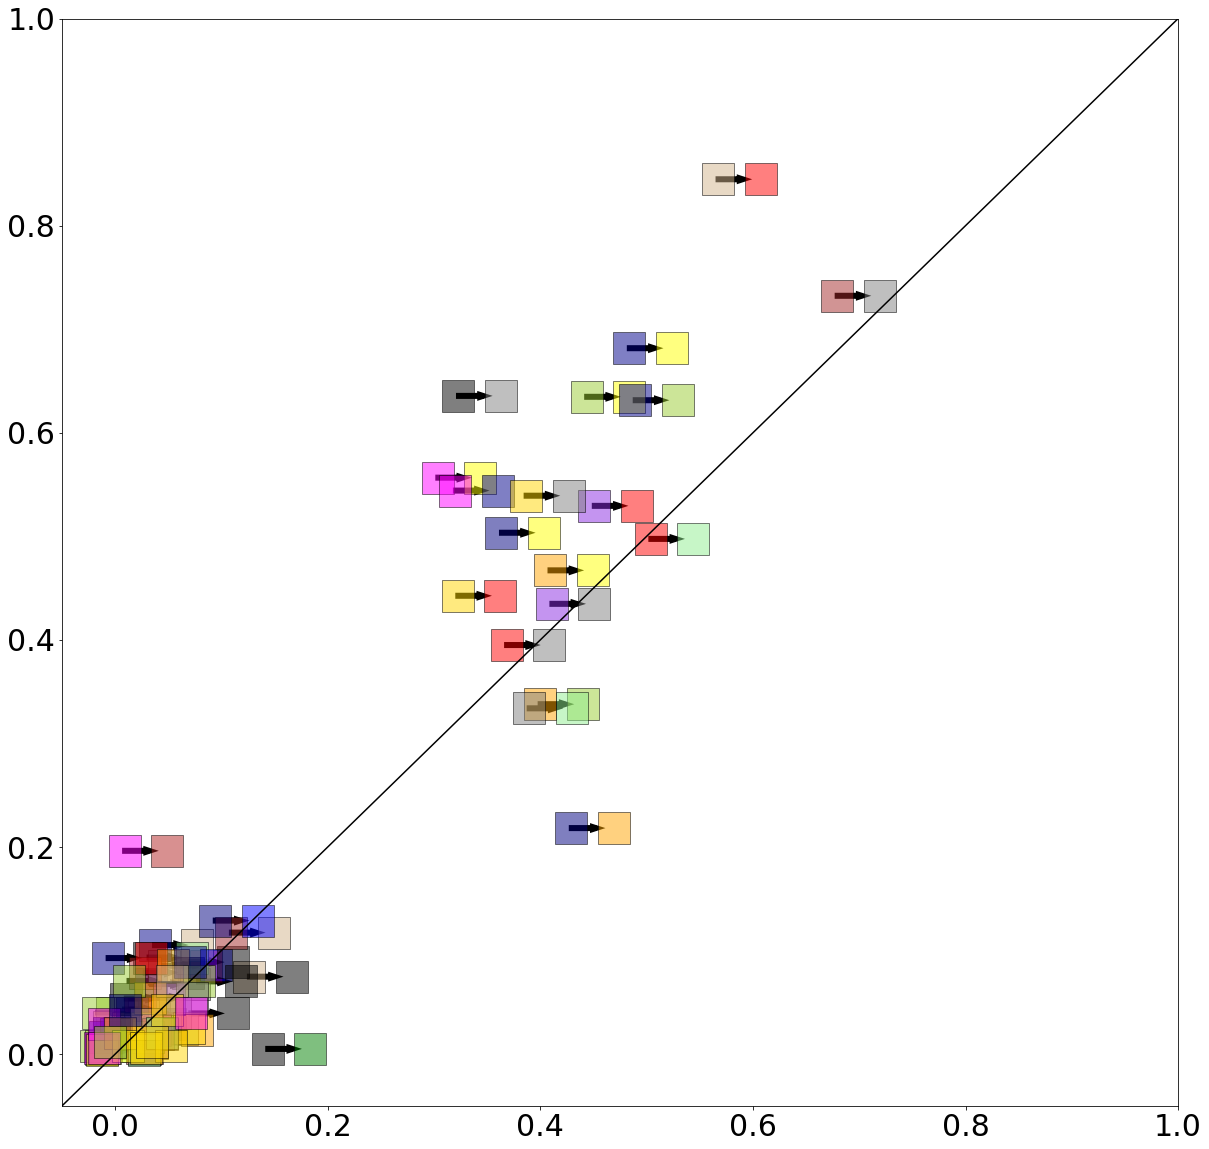

In [68]:
figsize(20,20)
#pal = sns.color_palette('bright',11)
for k in obs_lfs.index.values.tolist():
    for shkey in shared_keys:
        if k[0]==int(shkey.split('_')[0]) and k[1][1]==int(shkey.split('_')[1]):
            x = (obs_lfs['gp1'].loc[k[0]])[k[1]]
            y = (obs_lfs['gp2'].loc[k[0]])[k[1]]
            plt.scatter(x-0.02,y, c= [pal[k[0]]], s = 1000,alpha = 0.5, linewidths=1, edgecolors='black', marker='s')

            new = list(set(list(k[1]))-set([k[0]]))[0]
            plt.scatter(x+0.02,y, c= [pal[new]], s= 1000,alpha = 0.5, linewidths=1, edgecolors='black', marker='s')
            plt.arrow(x-0.02,y,0.02,0,zorder = -10,lw = 5)
    #     if x>0.3 and y<0.1:
#         plt.text(x+0.03,y,cn_names[new],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#         plt.text(x-0.03,y,cn_names[k[0]],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#         print(cn_names[k[0]],'-',cn_names[new])
#     if x<0.1 and y>0.3:
#         plt.text(x+0.03,y,cn_names[new],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#         plt.text(x-0.03,y,cn_names[k[0]],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#         print(cn_names[k[0]],'-',cn_names[new])
#     if x>0.8 or y>0.8:
#         plt.text(x+0.03,y,cn_names[new],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#         plt.text(x-0.03,y,cn_names[k[0]],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#         print(cn_names[k[0]],'-',cn_names[new])
plt.ylim(-0.05,1)
plt.xlim(-0.05,1)
plt.xticks(fontsize = 30);
plt.yticks(fontsize = 30);
plt.plot([-0.5,1],[-0.5,1],c = 'black')
#plt.savefig(save_path+'window10_2-chain_frequency10_neigh_plasma_all.png',bbox_inches = 'tight')
plt.show()

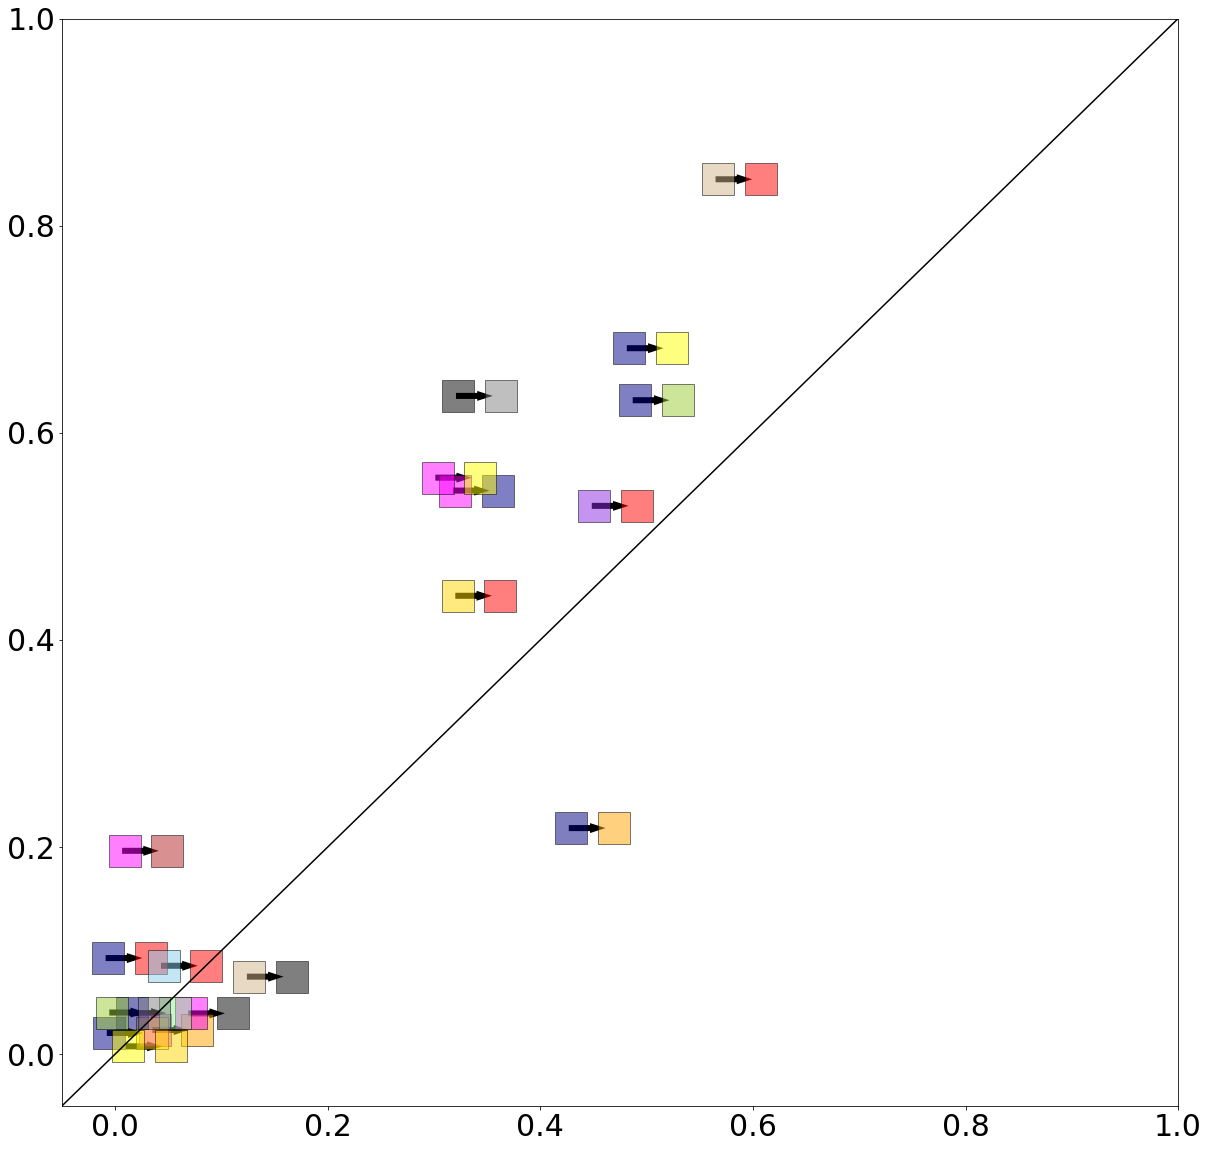

In [69]:
figsize(20,20)
#pal = sns.color_palette('bright',11)
for k in sig_lfs.index.values.tolist():
    for shkey in shared_keys:
        if k[0]==int(shkey.split('_')[0]) and k[1][1]==int(shkey.split('_')[1]):
            x = (sig_lfs['gp1'].loc[k[0]])[k[1]]
            y = (sig_lfs['gp2'].loc[k[0]])[k[1]]
            plt.scatter(x-0.02,y, c= [pal[k[0]]], s = 1000,alpha = 0.5, linewidths=1, edgecolors='black', marker='s')

            new = list(set(list(k[1]))-set([k[0]]))[0]
            plt.scatter(x+0.02,y, c= [pal[new]], s= 1000,alpha = 0.5, linewidths=1, edgecolors='black', marker='s')
            plt.arrow(x-0.02,y,0.02,0,zorder = -10,lw = 5)
    #     if x>0.3 and y<0.1:
#         plt.text(x+0.03,y,cn_names[new],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#         plt.text(x-0.03,y,cn_names[k[0]],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#         print(cn_names[k[0]],'-',cn_names[new])
#     if x<0.1 and y>0.3:
#         plt.text(x+0.03,y,cn_names[new],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#         plt.text(x-0.03,y,cn_names[k[0]],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#         print(cn_names[k[0]],'-',cn_names[new])
#     if x>0.8 or y>0.8:
#         plt.text(x+0.03,y,cn_names[new],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#         plt.text(x-0.03,y,cn_names[k[0]],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#         print(cn_names[k[0]],'-',cn_names[new])
plt.ylim(-0.05,1)
plt.xlim(-0.05,1)
plt.xticks(fontsize = 30);
plt.yticks(fontsize = 30);
plt.plot([-0.5,1],[-0.5,1],c = 'black')
#plt.savefig(save_path+'window10_2-chain_frequency10_neigh_plasma_all.png',bbox_inches = 'tight')
plt.show()

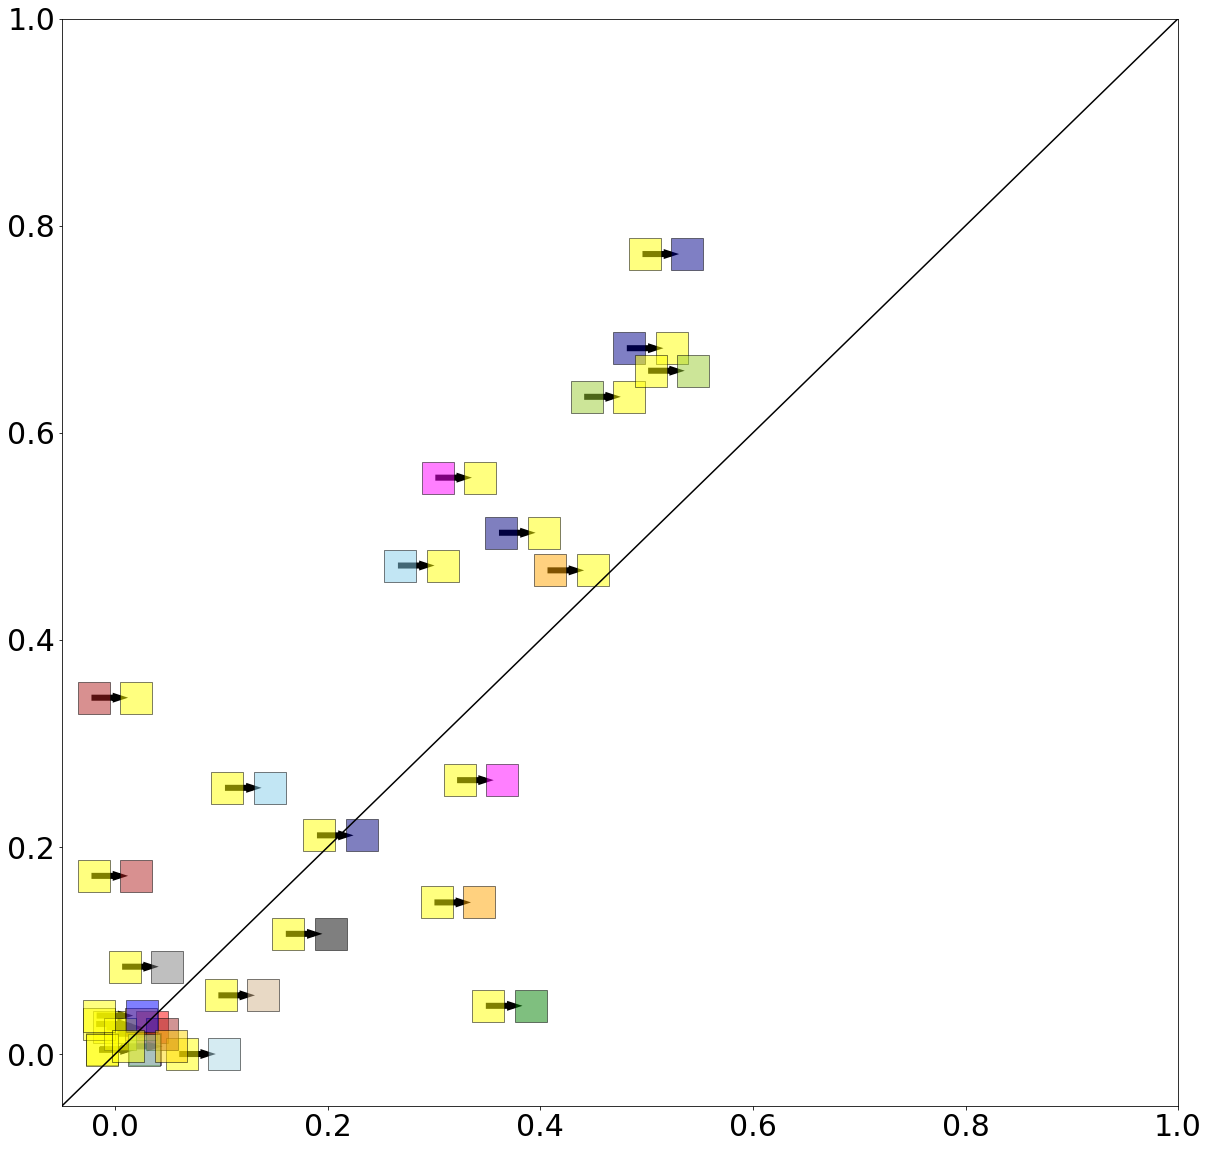

In [34]:
figsize(20,20)
#pal = sns.color_palette('bright',11)
for k in obs_lfs.index.values.tolist():
    if k[0]==7 or k[1][1]==7:
        x = (obs_lfs['gp1'].loc[k[0]])[k[1]]
        y = (obs_lfs['gp2'].loc[k[0]])[k[1]]
        plt.scatter(x-0.02,y, c= [pal[k[0]]], s = 1000,alpha = 0.5, linewidths=1, edgecolors='black', marker='s')

        new = list(set(list(k[1]))-set([k[0]]))[0]
        plt.scatter(x+0.02,y, c= [pal[new]], s= 1000,alpha = 0.5, linewidths=1, edgecolors='black', marker='s')
        plt.arrow(x-0.02,y,0.02,0,zorder = -10,lw = 5)
    #     if x>0.3 and y<0.1:
#         plt.text(x+0.03,y,cn_names[new],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#         plt.text(x-0.03,y,cn_names[k[0]],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#         print(cn_names[k[0]],'-',cn_names[new])
#     if x<0.1 and y>0.3:
#         plt.text(x+0.03,y,cn_names[new],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#         plt.text(x-0.03,y,cn_names[k[0]],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#         print(cn_names[k[0]],'-',cn_names[new])
#     if x>0.8 or y>0.8:
#         plt.text(x+0.03,y,cn_names[new],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#         plt.text(x-0.03,y,cn_names[k[0]],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#         print(cn_names[k[0]],'-',cn_names[new])
plt.ylim(-0.05,1)
plt.xlim(-0.05,1)
plt.xticks(fontsize = 30);
plt.yticks(fontsize = 30);
plt.plot([-0.5,1],[-0.5,1],c = 'black')
plt.savefig(save_path+'window10_2-chain_frequency10_neigh_plasma_all.png',bbox_inches = 'tight')
plt.show()

In [36]:
save_path

'G:/HuBMAP/B008_12/analysis/context/'

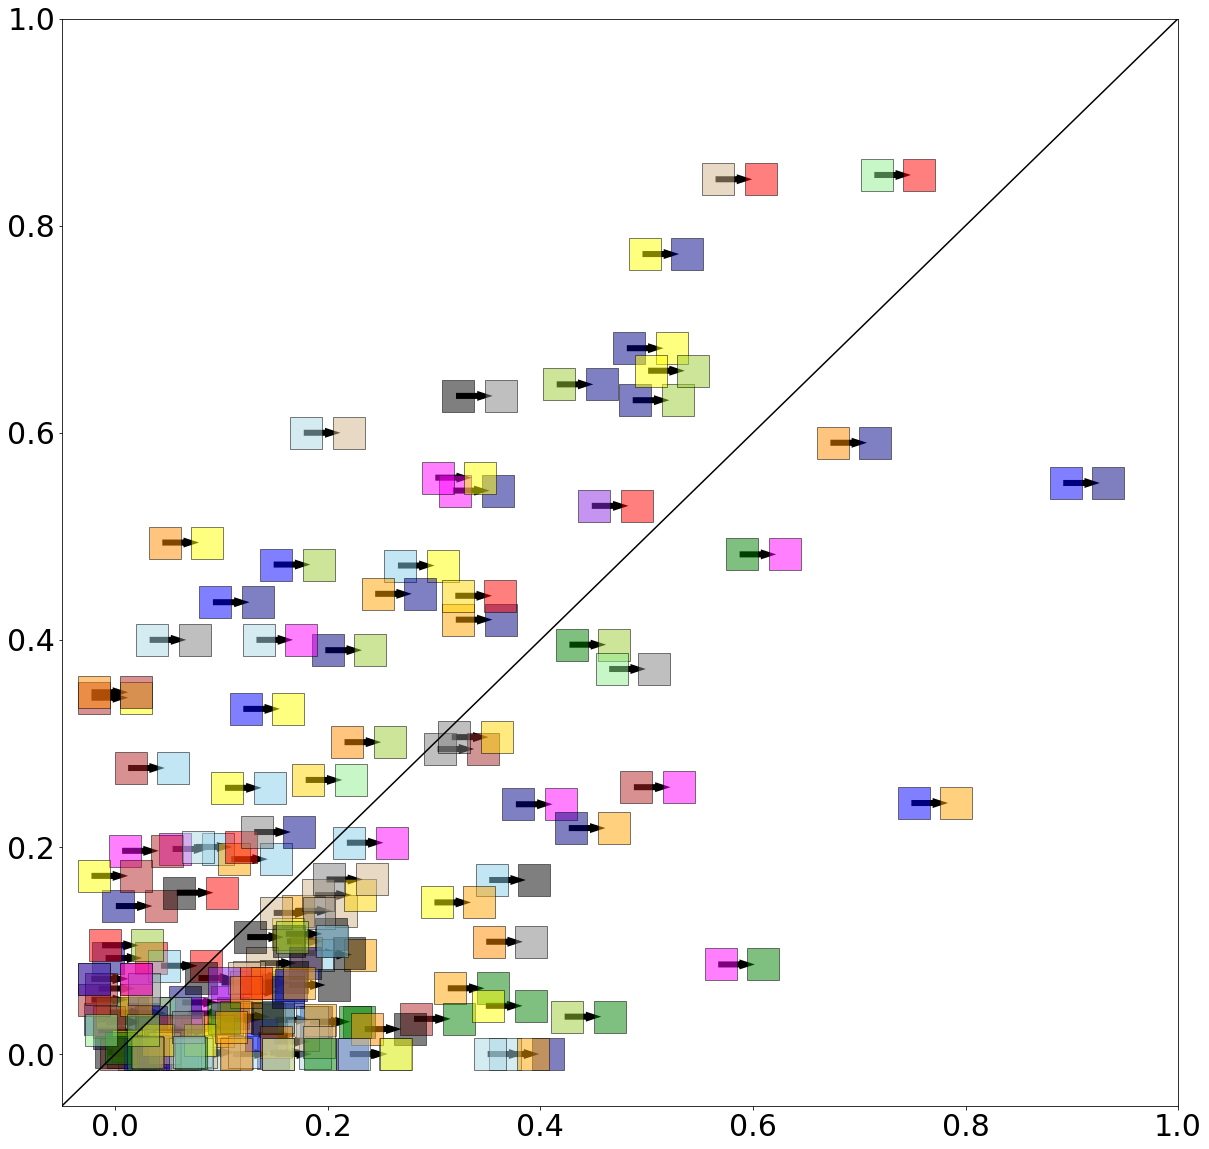

In [37]:
figsize(20,20)
#pal = sns.color_palette('bright',11)
for k in sig_lfs.index.values.tolist():
    x = (sig_lfs['gp1'].loc[k[0]])[k[1]]
    y = (sig_lfs['gp2'].loc[k[0]])[k[1]]
    plt.scatter(x-0.02,y, c= [pal[k[0]]], s = 1000,alpha = 0.5, linewidths=1, edgecolors='black', marker='s')
   
    new = list(set(list(k[1]))-set([k[0]]))[0]
    plt.scatter(x+0.02,y, c= [pal[new]], s= 1000,alpha = 0.5, linewidths=1, edgecolors='black', marker='s')
    plt.arrow(x-0.02,y,0.02,0,zorder = -10,lw = 5)
#     if x>0.3 and y<0.1:
#         plt.text(x+0.03,y,cn_names[new],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#         plt.text(x-0.03,y,cn_names[k[0]],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#         print(cn_names[k[0]],'-',cn_names[new])
#     if x<0.1 and y>0.3:
#         plt.text(x+0.03,y,cn_names[new],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#         plt.text(x-0.03,y,cn_names[k[0]],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#         print(cn_names[k[0]],'-',cn_names[new])
#     if x>0.8 or y>0.8:
#         plt.text(x+0.03,y,cn_names[new],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#         plt.text(x-0.03,y,cn_names[k[0]],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#         print(cn_names[k[0]],'-',cn_names[new])
plt.ylim(-0.05,1)
plt.xlim(-0.05,1)
plt.xticks(fontsize = 30);
plt.yticks(fontsize = 30);
plt.plot([-0.5,1],[-0.5,1],c = 'black')
plt.savefig(save_path+'window10_2-chain_frequency10_neigh.png',bbox_inches = 'tight')
plt.show()


0 - 14
4 - 14
5 - 14
6 - 7
6 - 14
7 - 14
13 - 6
13 - 7
17 - 3
17 - 4
17 - 18


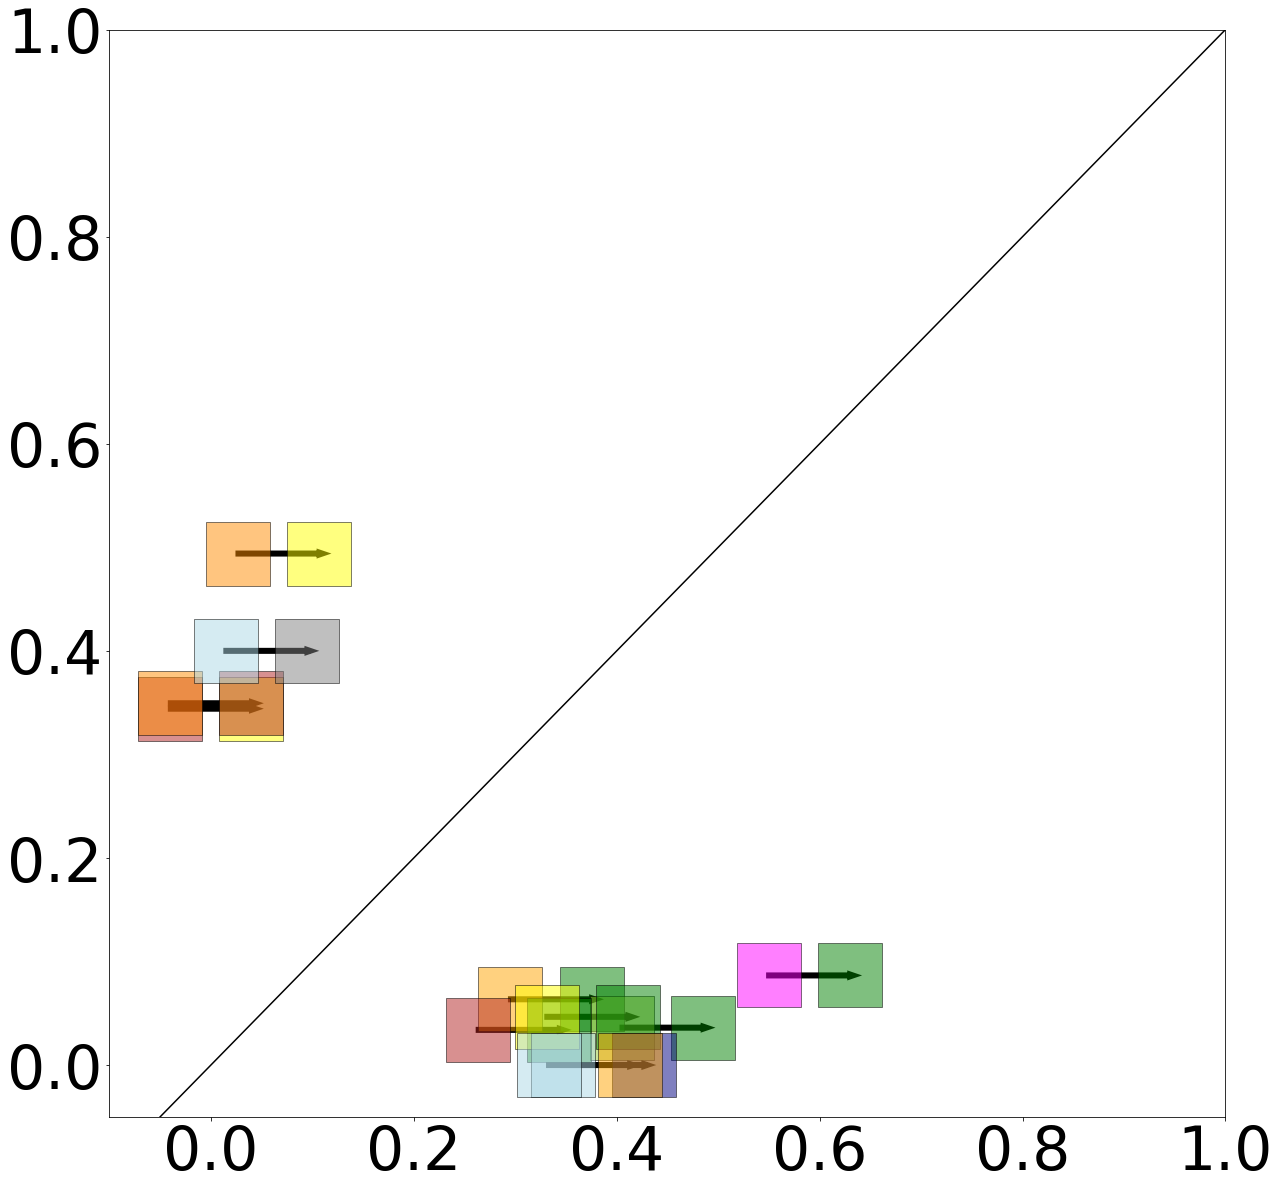

In [38]:
figsize(20,20)
#pal = sns.color_palette('bright',11)
for k in sig_lfs.index.values.tolist():
    x = (sig_lfs['gp1'].loc[k[0]])[k[1]]
    y = (sig_lfs['gp2'].loc[k[0]])[k[1]]
    if x>0.3 and y<0.1:
        plt.scatter(x-0.04,y, c= [pal[k[0]]], s = 4000,alpha = 0.5, linewidths=1, edgecolors='black', marker='s')

        new = list(set(list(k[1]))-set([k[0]]))[0]
        plt.scatter(x+0.04,y, c= [pal[new]], s= 4000,alpha = 0.5, linewidths=1, edgecolors='black', marker='s')
        plt.arrow(x-0.04,y,0.08,0,zorder = -10,lw = 5)
        print(cn_names[k[0]],'-',cn_names[new])
    if x<0.1 and y>0.3:
        plt.scatter(x-0.04,y, c= [pal[k[0]]], s = 4000,alpha = 0.5, linewidths=1, edgecolors='black', marker='s')

        new = list(set(list(k[1]))-set([k[0]]))[0]
        plt.scatter(x+0.04,y, c= [pal[new]], s= 4000,alpha = 0.5, linewidths=1, edgecolors='black', marker='s')
        plt.arrow(x-0.04,y,0.08,0,zorder = -10,lw = 5)
        print(cn_names[k[0]],'-',cn_names[new])
#         if x>0.3 and y<0.1:
#             plt.text(x+0.03,y,cn_names[new],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#             plt.text(x-0.03,y,cn_names[k[0]],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#             print(cn_names[k[0]],'-',cn_names[new])
#         if x<0.1 and y>0.3:
#             plt.text(x+0.03,y,cn_names[new],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#             plt.text(x-0.03,y,cn_names[k[0]],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#             print(cn_names[k[0]],'-',cn_names[new])
#         if x>0.5 or y>0.5:
#             plt.text(x+0.03,y,cn_names[new],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#             plt.text(x-0.03,y,cn_names[k[0]],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#             print(cn_names[k[0]],'-',cn_names[new])
plt.ylim(-0.05,1)
plt.xlim(-0.1,1)
plt.xticks(fontsize = 60);
plt.yticks(fontsize = 60);
plt.plot([-0.5,1],[-0.5,1],c = 'black')
plt.savefig(save_path+'window10_2-chain_frequency10_sig.png',bbox_inches = 'tight')
plt.show()

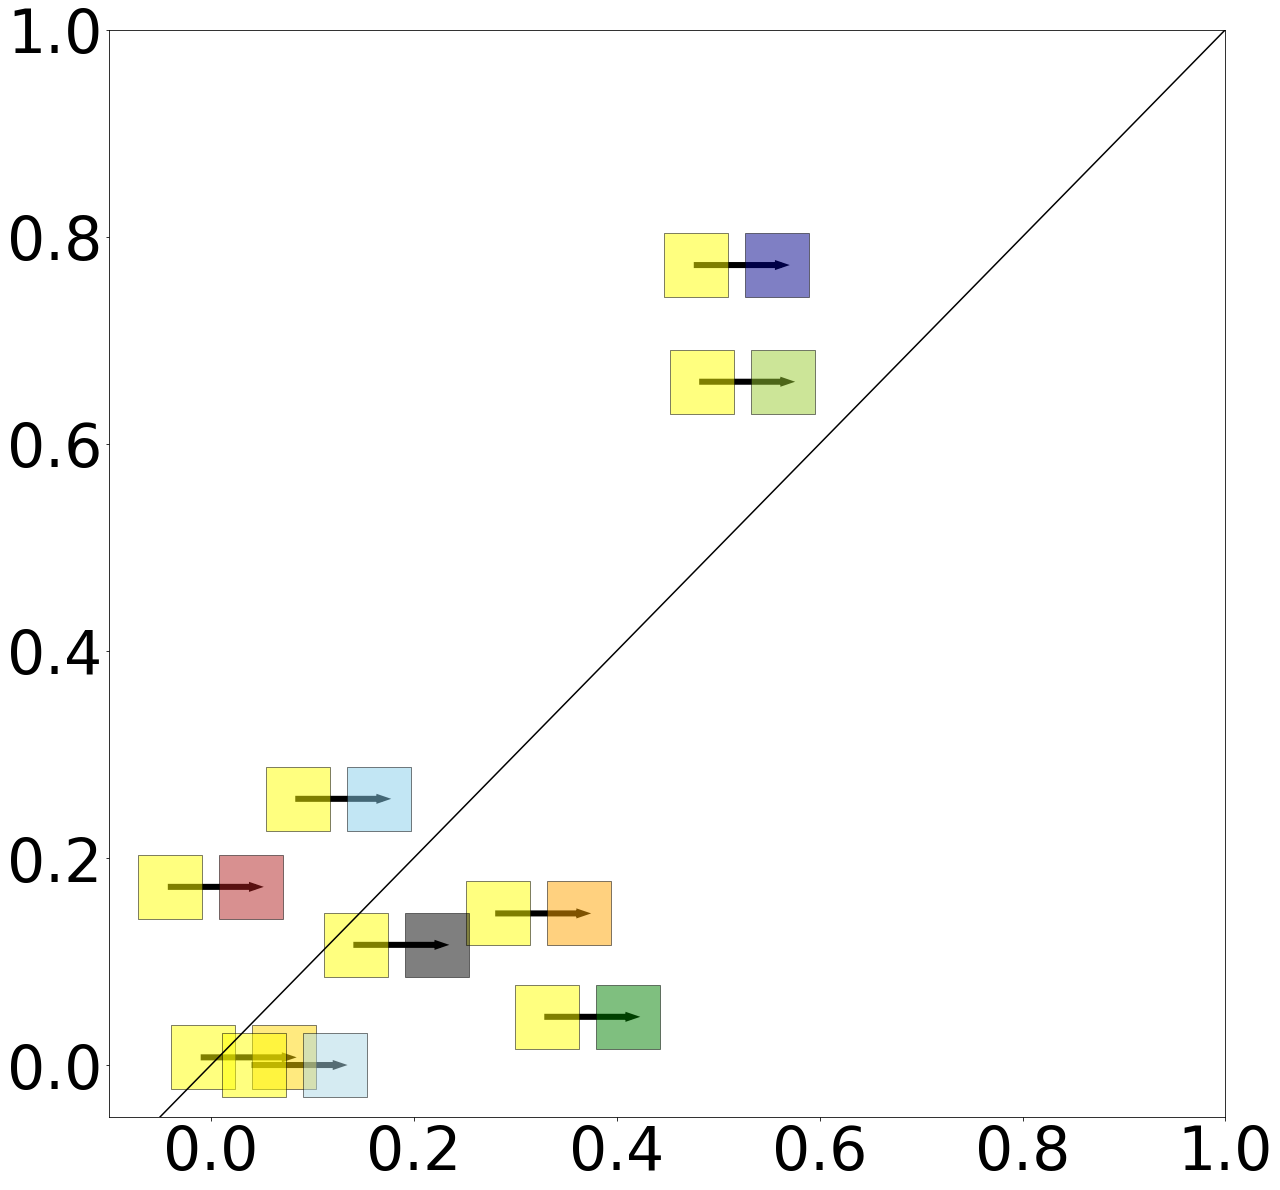

In [39]:
figsize(20,20)
#pal = sns.color_palette('bright',11)
for k in sig_lfs.index.values.tolist():
    if k[0]==7 or k[1]==7:
        x = (sig_lfs['gp1'].loc[k[0]])[k[1]]
        y = (sig_lfs['gp2'].loc[k[0]])[k[1]]
        plt.scatter(x-0.04,y, c= [pal[k[0]]], s = 4000,alpha = 0.5, linewidths=1, edgecolors='black', marker='s')

        new = list(set(list(k[1]))-set([k[0]]))[0]
        plt.scatter(x+0.04,y, c= [pal[new]], s= 4000,alpha = 0.5, linewidths=1, edgecolors='black', marker='s')
        plt.arrow(x-0.04,y,0.08,0,zorder = -10,lw = 5)
#         if x>0.3 and y<0.1:
#             plt.text(x+0.03,y,cn_names[new],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#             plt.text(x-0.03,y,cn_names[k[0]],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#             print(cn_names[k[0]],'-',cn_names[new])
#         if x<0.1 and y>0.3:
#             plt.text(x+0.03,y,cn_names[new],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#             plt.text(x-0.03,y,cn_names[k[0]],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#             print(cn_names[k[0]],'-',cn_names[new])
#         if x>0.5 or y>0.5:
#             plt.text(x+0.03,y,cn_names[new],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#             plt.text(x-0.03,y,cn_names[k[0]],fontsize = 40,va = 'bottom',ha = 'left',weight = 'bold')
#             print(cn_names[k[0]],'-',cn_names[new])
plt.ylim(-0.05,1)
plt.xlim(-0.1,1)
plt.xticks(fontsize = 60);
plt.yticks(fontsize = 60);
plt.plot([-0.5,1],[-0.5,1],c = 'black')
plt.savefig(save_path+'window10_2-chain_frequency10_plasma.png',bbox_inches = 'tight')
plt.show()


In [40]:
neigh_num

{'Mature Epithelial': 0,
 'Transit Amplifying Zone': 1,
 'Innate Immune Enriched': 2,
 'Outer Follicle': 3,
 'Adaptive Immune Enriched': 4,
 'Secretory Epithelial': 5,
 'CD66+ Mature Epithelial': 6,
 'Plasma Cell Enriched': 7,
 'Stroma & Innate Immune': 8,
 'Smooth Muscle & Innate Immune': 9,
 'Microvasculature': 10,
 'Innervated Stroma': 11,
 'Inner Follicle': 12,
 'Glandular Epithelial': 13,
 'CD8+ T Enriched IEL': 14,
 'Macrovasculature': 15,
 'Smooth Muscle': 16,
 'Paneth Enriched': 17,
 'Stroma': 18,
 'Innervated Smooth Muscle': 19}

# Motifs deviant from max. ent. null

## 2-chains

In [41]:
# generate a random map respecting the structure as defined by the partition
np.random.seed(23)

null_dist = []
for i in range(10000):
    permutation = {}
    for isom,equiv_class in nodes_by_isom['SB'].items():
        block0 = list(equiv_class)
        block1 = block0.copy()
        np.random.shuffle(block1)
        permutation.update({a:b for a,b in zip(block0,block1)})

    # now get a new graph (group 1 for now) 
    perm_graph = nx.Graph()
    for s,t in adj_graphs['SB'].edges():
        perm_graph.add_edge(permutation[s], permutation[t])

    # compute the statistic
    null_dist.append(pd.DataFrame({i:total_edgetype_counts(perm_graph)}))
edge_null_dist = pd.concat(null_dist,axis = 1).fillna(0)

# now we see which ones are significant after bonferroni
edge_observed = pd.DataFrame({'obs':total_edgetype_counts(adj_graphs['SB'])})
edge_null_distfill = edge_null_dist.fillna(0) # fillna 0 is OK because it's just the missing ones from each spot
corrected_pvalues = {}
for pair in edge_observed.index.values:
    s1 = 1-np.mean(edge_null_distfill.loc[pair].values < edge_observed.loc[pair]['obs'])
    s2 = 1-np.mean(edge_null_distfill.loc[pair].values > edge_observed.loc[pair]['obs'])
    # leave correction until later
    corrected_pvalues[pair] = min(s1,s2)#min(1,2*len(edge_observed.index.values) * min(s1,s2))

corrected = pd.DataFrame({'p':corrected_pvalues})
good1 = edge_observed.loc[edge_observed['obs'] >5]
meds1 = np.median(np.log2(good1.values/(1+edge_null_distfill.loc[good1.index.values].values)),axis = 1)
pv1 = corrected.loc[good1.index.values]

In [42]:
# generate a random map respecting the structure as defined by the partition
np.random.seed(23)

null_dist = []
for i in range(10000):
    permutation = {}
    for isom,equiv_class in nodes_by_isom['CL'].items():
        block0 = list(equiv_class)
        block1 = block0.copy()
        np.random.shuffle(block1)
        permutation.update({a:b for a,b in zip(block0,block1)})

    # now get a new graph (group 2 for now) 
    perm_graph = nx.Graph()
    for s,t in adj_graphs['CL'].edges():
        perm_graph.add_edge(permutation[s], permutation[t])

    # compute the statistic
    null_dist.append(pd.DataFrame({i:total_edgetype_counts(perm_graph)}))
edge_null_dist = pd.concat(null_dist,axis = 1).fillna(0)

# now we see which ones are significant after bonferroni
edge_observed = pd.DataFrame({'obs':total_edgetype_counts(adj_graphs['CL'])})
edge_null_distfill = edge_null_dist.fillna(0) # fillna 0 is OK because it's just the missing ones from each spot
corrected_pvalues = {}
for pair in edge_observed.index.values:
    s1 = 1-np.mean(edge_null_distfill.loc[pair].values < edge_observed.loc[pair]['obs'])
    s2 = 1-np.mean(edge_null_distfill.loc[pair].values > edge_observed.loc[pair]['obs'])
    # leave correction until later
    corrected_pvalues[pair] = min(s1,s2)#min(1,2*len(edge_observed.index.values) * min(s1,s2))

corrected = pd.DataFrame({'p':corrected_pvalues})
good2 = edge_observed.loc[edge_observed['obs'] >5]
meds2 = np.median(np.log2(good2.values/(1+edge_null_distfill.loc[good2.index.values].values)),axis = 1)
pv2 = corrected.loc[good2.index.values]

In [43]:
pv1_2ch = pv1.copy()
meds1_1ch = meds1.copy()
pv2_2ch = pv2.copy()
meds2_2ch = meds2.copy()

0 - 1 :  0.5064166658639562
0 - 3 :  -1.920096134407786
0 - 4 :  -1.310678953754403
0 - 5 :  0.4385481347543009
0 - 6 :  1.2054691182999795
0 - 7 :  0.7643070412824041
0 - 8 :  -3.422532035825768
0 - 9 :  -3.6641891918717313
0 - 10 :  -1.0155548141948418
0 - 14 :  1.0541252138609678
0 - 15 :  -3.693022246578609
0 - 17 :  -1.2530565946382177
0 - 18 :  -1.7762250246134332
0 - 19 :  -5.670064136850294
1 - 5 :  0.9817466805628668
1 - 7 :  1.4413432618321331
1 - 8 :  -2.39391420771309
1 - 9 :  -1.2617410888122733
1 - 10 :  -1.0603539068309487
1 - 11 :  -2.6755650495020626
1 - 13 :  1.8328900141647417
1 - 14 :  -0.24726708997547722
1 - 15 :  -3.145677455195635
1 - 16 :  -3.18322182405577
1 - 17 :  1.005475130066151
1 - 18 :  -0.7250353840832242
1 - 19 :  -3.2552570552420748
2 - 3 :  -0.6364928013612383
2 - 10 :  0.7336065820762915
2 - 16 :  -0.6651328494051395
2 - 17 :  -0.9499593175004044
2 - 19 :  -1.1080597458574528
3 - 4 :  1.465319253721667
3 - 5 :  -0.47237067434479546
3 - 7 :  0.62574

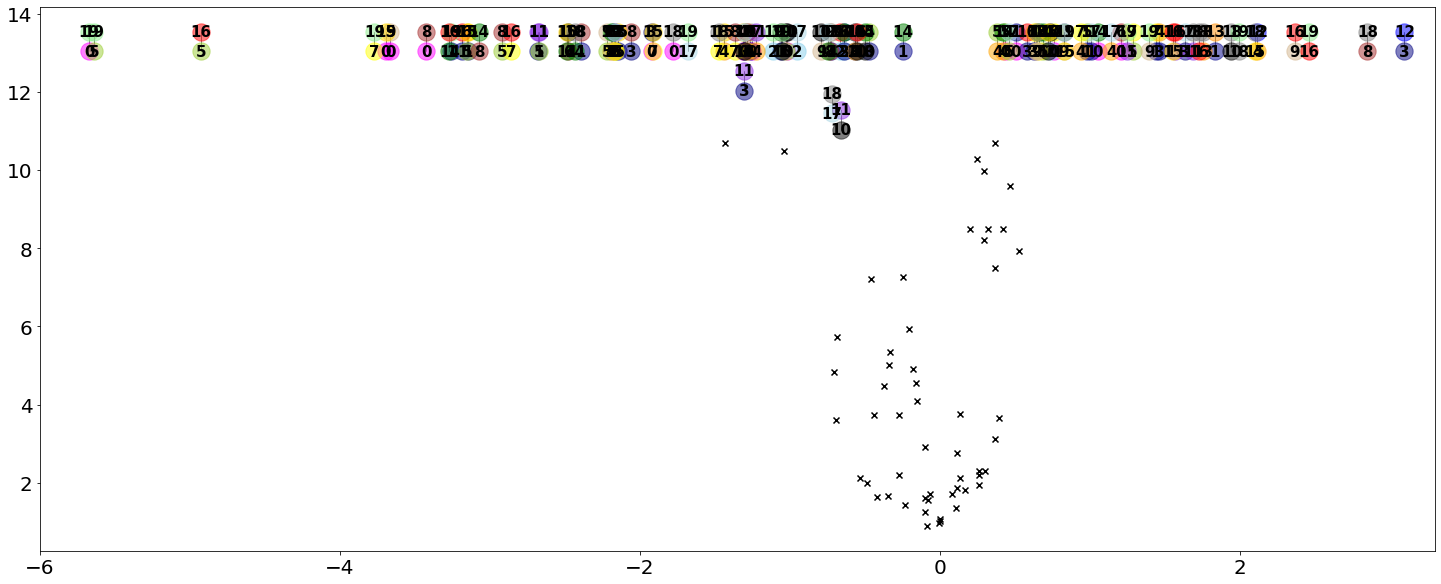

In [44]:
SB_dict = {}
figsize(25,10)
for j,name in enumerate(pv1_2ch.index.values):
    z = 0
    u = meds1_1ch[j]
    v = -np.log2(1e-4+pv1_2ch.values[j])
   
    if pv1_2ch.values[j]<0.05/len(pv1_2ch):
        a,b = name
        plt.scatter(u,v-0.25, c=  [pal[a]],s = 300,alpha = 0.5)
        plt.scatter(u,v+0.25, c=  [pal[b]], s = 300,alpha = 0.5)
        plt.text(u,v-0.25, cn_names[a], ha = 'center', va = 'center',fontsize = 15, weight = 'bold')
        plt.text(u,v+0.25, cn_names[b], ha = 'center', va = 'center', fontsize = 15, weight = 'bold')
        plt.plot([u,u],[v-0.25,v+0.25], c = 'black',lw = .5,zorder = -10)
        print(cn_names[a],'-',cn_names[b],': ',u)
        SB_dict[str(cn_names[a])+'_'+str(cn_names[b])]=u
    else:
        plt.scatter(u,v, c = ['black'],marker = 'x')
        

plt.xlim(-6,3.3)

plt.xticks(fontsize = 20);
plt.yticks(fontsize = 20);
plt.savefig(save_path+'window10_2-chain_10_SB.png',bbox_inches = 'tight')

In [45]:
neigh_num

{'Mature Epithelial': 0,
 'Transit Amplifying Zone': 1,
 'Innate Immune Enriched': 2,
 'Outer Follicle': 3,
 'Adaptive Immune Enriched': 4,
 'Secretory Epithelial': 5,
 'CD66+ Mature Epithelial': 6,
 'Plasma Cell Enriched': 7,
 'Stroma & Innate Immune': 8,
 'Smooth Muscle & Innate Immune': 9,
 'Microvasculature': 10,
 'Innervated Stroma': 11,
 'Inner Follicle': 12,
 'Glandular Epithelial': 13,
 'CD8+ T Enriched IEL': 14,
 'Macrovasculature': 15,
 'Smooth Muscle': 16,
 'Paneth Enriched': 17,
 'Stroma': 18,
 'Innervated Smooth Muscle': 19}

0 - 1 :  0.348585849949007
0 - 3 :  -1.7757848430567342
0 - 4 :  -1.7318038890504273
0 - 6 :  0.6713772525386293
0 - 7 :  0.9927684307689242
0 - 8 :  -3.21501289097085
0 - 9 :  -2.261265312980738
0 - 10 :  -2.321928094887362
0 - 15 :  -4.11150831521699
0 - 16 :  -2.5670405927238935
0 - 18 :  -2.0677446066358343
1 - 3 :  0.37386525839736473
1 - 5 :  0.8672902927028311
1 - 7 :  1.5739073122121603
1 - 8 :  -2.807354922057604
1 - 9 :  -0.7150824762677563
1 - 10 :  -1.2455204421460186
1 - 11 :  -3.5647846187835257
1 - 15 :  -2.535037275389474
1 - 16 :  -0.4785115590905135
1 - 18 :  -0.478834149859813
1 - 19 :  -3.004501392234941
2 - 5 :  0.3187398172563149
2 - 6 :  1.2169585352858199
2 - 7 :  0.8160817264781878
2 - 9 :  -1.2030918653775116
2 - 11 :  -1.4854268271702418
2 - 15 :  -1.7681843247769262
2 - 16 :  -0.6780719051126377
2 - 18 :  1.0138057995250305
2 - 19 :  -2.321928094887362
3 - 4 :  1.7055526415347446
3 - 6 :  -1.9114633253983428
3 - 7 :  0.9073690220897357
3 - 8 :  -2.0951572330

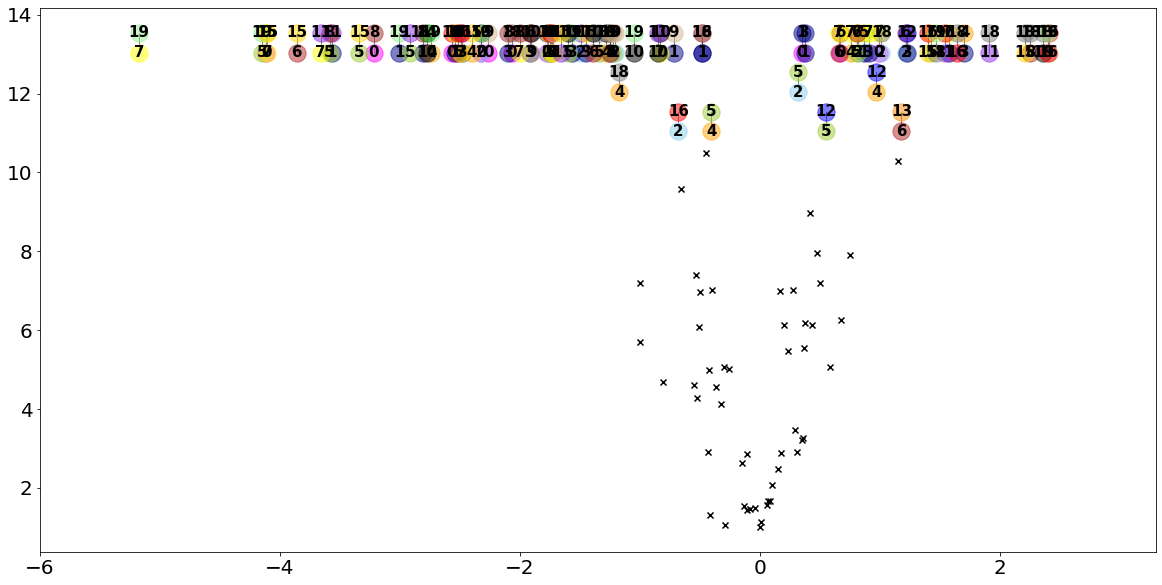

In [46]:
CL_dict = {}
figsize(20,10)
for j,name in enumerate(pv2_2ch.index.values):
    z = 0
    u = meds2_2ch[j]
    v = -np.log2(1e-4+pv2_2ch.values[j])
   
    if pv2_2ch.values[j]<0.05/len(pv2):
        a,b = name
        plt.scatter(u,v-0.25, c=  [pal[a]],s = 300,alpha = 0.5)
        plt.scatter(u,v+0.25, c=  [pal[b]], s = 300,alpha = 0.5)
        plt.text(u,v-0.25, cn_names[a], ha = 'center', va = 'center',fontsize = 15, weight = 'bold')
        plt.text(u,v+0.25, cn_names[b], ha = 'center', va = 'center', fontsize = 15, weight = 'bold')
        plt.plot([u,u],[v-0.25,v+0.25], c = 'black',lw = .5,zorder = -10)
        print(cn_names[a],'-',cn_names[b],': ',u)
        CL_dict[str(cn_names[a])+'_'+str(cn_names[b])]=u
    else:
        plt.scatter(u,v, c = ['black'],marker = 'x')
        

plt.xlim(-6,3.3);

plt.xticks(fontsize = 20);
plt.yticks(fontsize = 20);
plt.savefig(save_path+'window10_2-chain_10_CL.png',bbox_inches = 'tight')

In [59]:
shared_keys

['3_8',
 '2_16',
 '4_19',
 '1_19',
 '10_18',
 '7_16',
 '1_7',
 '1_11',
 '3_15',
 '15_16',
 '11_16',
 '7_11',
 '0_15',
 '0_18',
 '10_19',
 '16_18',
 '4_7',
 '3_4',
 '0_9',
 '6_10',
 '4_12',
 '3_12',
 '5_9',
 '5_11',
 '1_8',
 '0_8',
 '7_8',
 '0_10',
 '9_16',
 '3_7',
 '3_11',
 '0_3',
 '1_16',
 '1_9',
 '8_9',
 '2_19',
 '0_4',
 '5_10',
 '7_19',
 '10_14',
 '5_8',
 '4_5',
 '1_18',
 '16_19',
 '3_19',
 '0_1',
 '5_19',
 '5_18',
 '0_7',
 '1_10',
 '18_19',
 '4_15',
 '9_10',
 '7_15',
 '8_18',
 '4_18',
 '5_7',
 '0_6',
 '4_8',
 '11_18',
 '5_15',
 '1_5',
 '1_15',
 '10_11',
 '15_18',
 '5_16']

In [47]:
shared_keys = list(set(CL_dict.keys() ) & set(SB_dict.keys() ) )
SB_keys = list(set(SB_dict.keys()) - set(CL_dict.keys()))
CL_keys = list(set(CL_dict.keys()) - set(SB_dict.keys())) 

In [60]:
SB_dict['1_5']

0.9817466805628668

In [48]:
thres = 2
shared_neg_keys = []
shared_pos_keys = []
shared_SBpos_keys = []
shared_CLpos_keys = []
for k1 in shared_keys:
    if CL_dict[k1]<-thres and SB_dict[k1]<-thres:
        shared_neg_keys.append(k1)
    elif CL_dict[k1]<-thres and SB_dict[k1]>thres:
        shared_SBpos_keys.append(k1)  
    elif CL_dict[k1]>thres and SB_dict[k1]<-thres:
        shared_CLpos_keys.append(k1)    
    elif CL_dict[k1]>thres and SB_dict[k1]>thres:
        shared_pos_keys.append(k1)
        
SB_neg_keys = []
SB_pos_keys = []
for k1 in SB_keys:
    if SB_dict[k1]<0:
        SB_neg_keys.append(k1)
    elif SB_dict[k1]>0:
        SB_pos_keys.append(k1)  
        
CL_neg_keys = []
CL_pos_keys = []
for k1 in CL_keys:
    if CL_dict[k1]<0:
        CL_neg_keys.append(k1)
    elif CL_dict[k1]>0:
        CL_pos_keys.append(k1)  

In [49]:
shared_neg_keys

['3_8',
 '4_19',
 '1_19',
 '7_16',
 '1_11',
 '7_11',
 '0_15',
 '0_9',
 '5_11',
 '1_8',
 '0_8',
 '7_19',
 '5_8',
 '5_19',
 '5_15',
 '1_15']

In [50]:
neigh_num

{'Mature Epithelial': 0,
 'Transit Amplifying Zone': 1,
 'Innate Immune Enriched': 2,
 'Outer Follicle': 3,
 'Adaptive Immune Enriched': 4,
 'Secretory Epithelial': 5,
 'CD66+ Mature Epithelial': 6,
 'Plasma Cell Enriched': 7,
 'Stroma & Innate Immune': 8,
 'Smooth Muscle & Innate Immune': 9,
 'Microvasculature': 10,
 'Innervated Stroma': 11,
 'Inner Follicle': 12,
 'Glandular Epithelial': 13,
 'CD8+ T Enriched IEL': 14,
 'Macrovasculature': 15,
 'Smooth Muscle': 16,
 'Paneth Enriched': 17,
 'Stroma': 18,
 'Innervated Smooth Muscle': 19}

In [51]:
shared_pos_keys

['9_16', '16_19', '8_18', '15_18']

In [52]:
shared_SBpos_keys

[]

In [53]:
shared_CLpos_keys

[]

In [54]:
SB_neg_keys

['17_18',
 '3_10',
 '10_17',
 '14_17',
 '15_17',
 '2_3',
 '14_15',
 '0_19',
 '7_18',
 '14_18',
 '8_14',
 '0_17',
 '3_5',
 '14_16',
 '10_16',
 '9_14',
 '4_11',
 '1_14',
 '17_19',
 '2_17',
 '3_14']

In [55]:
SB_pos_keys

['15_19',
 '9_15',
 '5_17',
 '9_19',
 '10_15',
 '11_19',
 '13_18',
 '1_13',
 '4_17',
 '3_17',
 '9_18',
 '9_11',
 '0_14',
 '5_14',
 '7_14',
 '4_14',
 '0_5',
 '1_17',
 '3_16',
 '2_10']

In [56]:
CL_neg_keys

['6_8',
 '4_10',
 '2_9',
 '2_11',
 '2_15',
 '0_16',
 '7_10',
 '3_6',
 '7_9',
 '11_15',
 '6_15']

In [57]:
CL_pos_keys

['1_3', '2_7', '2_18', '2_6', '5_12', '6_13', '6_7', '2_5', '5_6']

In [58]:
#interesting combinations (shared)
#Neg
#1,4 mature epithelial and adaptive immune enriched separated
#Pos
#4,5 secretory epithelial and adaptive immune enriched
#4,8 adaptive immune and stroma - boundary to submucosa
#4,9 adaptive immune and smooth muscle
#0,1 plasma cell enriched above this one
#0,5 secretory and mature epithelial with plasma
#0,4 adapitve immune and plasma
#8,9 stroma and smooth muscle



#interesting combinations (individual)
#0,2 positive in SB but not in CL
#organization of 6 within CL (mature epithelial location with respect to adaptive immune which is at the bottom)
#5 in negative - not close to mature, innate, stroma, follicle, at the bottom? follicle not by epithelial 1:3 